# K-Means Clustering Implementation
## Experiment 1: K-Means on Original Data

This notebook contains:
- K-Means implementation from scratch (K-Means++ and Random initialization)
- Experiment 1: Finding optimal k using multiple methods
- Complete evaluation with all metrics
- Visualizations and analysis

## Import Libraries

In [16]:
import numpy as np
import pandas as pd
from scipy.special import comb

## Load and Prepare Data

In [17]:
from sklearn.datasets import load_breast_cancer

# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
# Add the 'diagnosis' column (target variable) to the DataFrame
df['diagnosis'] = data.target

# Drop non-feature columns (adjust if needed), ensuring 'diagnosis' is not in X
X = df.drop(columns=['diagnosis']).values

# Standardization (important!)
X = (X - X.mean(axis=0)) / X.std(axis=0)

## K-Means Implementation from Scratch

Complete implementation including:
- K-Means++ initialization
- Random initialization
- Convergence criteria
- Inertia tracking

In [18]:


class KMeans:
    def __init__(
        self,
        n_clusters=3,
        init="kmeans++",   # "random" or "kmeans++"
        max_iter=300,
        tol=1e-4,
        random_state=None
    ):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        self.centroids = None
        self.labels_ = None
        self.inertia_history_ = []

    # ---------------------------
    # Initialization
    # ---------------------------
    def _init_random(self, X):
        rng = np.random.default_rng(self.random_state)
        indices = rng.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _init_kmeans_pp(self, X):
        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]

        centroids = []
        # choose first centroid randomly
        centroids.append(X[rng.integers(n_samples)])

        for _ in range(1, self.n_clusters):
            distances = np.min(
                np.linalg.norm(X[:, None, :] - np.array(centroids)[None, :, :], axis=2) ** 2,
                axis=1
            )
            probs = distances / np.sum(distances)
            next_centroid = X[rng.choice(n_samples, p=probs)]
            centroids.append(next_centroid)

        return np.array(centroids)

    # ---------------------------
    # Core steps
    # ---------------------------
    def _assign_clusters(self, X):
        distances = np.linalg.norm(
            X[:, None, :] - self.centroids[None, :, :],
            axis=2
        )
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        new_centroids = np.zeros_like(self.centroids)
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) == 0:
                new_centroids[k] = self.centroids[k]  # avoid empty cluster
            else:
                new_centroids[k] = np.mean(cluster_points, axis=0)
        return new_centroids

    def _compute_inertia(self, X, labels):
        inertia = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            inertia += np.sum((cluster_points - self.centroids[k]) ** 2)
        return inertia

    # ---------------------------
    # Fit
    # ---------------------------
    def fit(self, X):
        if self.init == "random":
            self.centroids = self._init_random(X)
        elif self.init == "kmeans++":
            self.centroids = self._init_kmeans_pp(X)
        else:
            raise ValueError("init must be 'random' or 'kmeans++'")

        for _ in range(self.max_iter):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)

            shift = np.linalg.norm(self.centroids - new_centroids)
            self.centroids = new_centroids

            inertia = self._compute_inertia(X, labels)
            self.inertia_history_.append(inertia)

            if shift < self.tol:
                break

        self.labels_ = labels
        return self

    # ---------------------------
    # Predict
    # ---------------------------
    def predict(self, X):
        distances = np.linalg.norm(
            X[:, None, :] - self.centroids[None, :, :],
            axis=2
        )
        return np.argmin(distances, axis=1)


## Silhouette Score Implementation

In [19]:
def silhouette_score(X, labels):
    n = X.shape[0]
    unique_labels = np.unique(labels)

    silhouette_vals = []

    for i in range(n):
        same_cluster = labels == labels[i]
        other_clusters = labels != labels[i]

        # a(i): mean intra-cluster distance
        a = np.mean(np.linalg.norm(X[i] - X[same_cluster], axis=1))

        # b(i): minimum mean distance to other clusters
        b = np.inf
        for label in unique_labels:
            if label == labels[i]:
                continue
            cluster_points = X[labels == label]
            dist = np.mean(np.linalg.norm(X[i] - cluster_points, axis=1))
            b = min(b, dist)

        silhouette_vals.append((b - a) / max(a, b))

    return np.mean(silhouette_vals)


## Find Optimal k Using Multiple Methods

In [20]:

k_values = range(2, 11)

results = {
    "k": [],
    "inertia": [],
    "silhouette": [],
    "iterations": []
}

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        init="kmeans++",
        max_iter=300,
        tol=1e-4,
        random_state=42
    )

    kmeans.fit(X)

    results["k"].append(k)
    results["inertia"].append(kmeans.inertia_history_[-1])
    results["silhouette"].append(silhouette_score(X, kmeans.labels_))
    results["iterations"].append(len(kmeans.inertia_history_))

In [21]:
def run_kmeans(init_type):
    inertias = []
    iters = []

    for k in k_values:
        km = KMeans(
            n_clusters=k,
            init=init_type,
            max_iter=300,
            tol=1e-4,
            random_state=42
        )
        km.fit(X)
        inertias.append(km.inertia_history_[-1])
        iters.append(len(km.inertia_history_))

    return inertias, iters


inertia_random, iter_random = run_kmeans("random")
inertia_pp, iter_pp = run_kmeans("kmeans++")


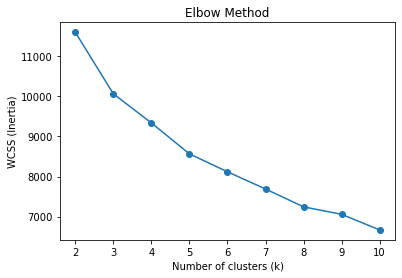

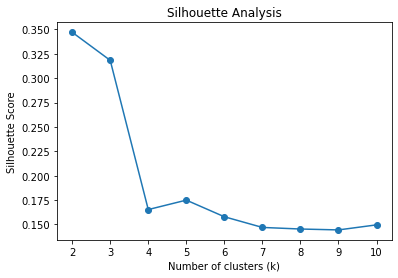

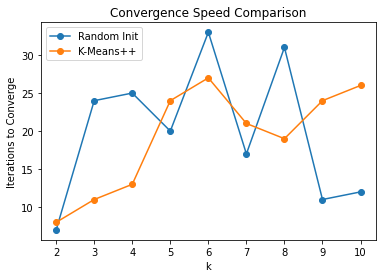

In [22]:
import matplotlib.pyplot as plt

# Elbow curve
plt.figure()
plt.plot(k_values, results["inertia"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method")
plt.show()

# Silhouette curve
plt.figure()
plt.plot(k_values, results["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

# Convergence comparison
plt.figure()
plt.plot(k_values, iter_random, label="Random Init", marker="o")
plt.plot(k_values, iter_pp, label="K-Means++", marker="o")
plt.xlabel("k")
plt.ylabel("Iterations to Converge")
plt.legend()
plt.title("Convergence Speed Comparison")
plt.show()


## Davies-Bouldin Index Implementation

In [23]:
def davies_bouldin_index(X, labels, centroids):
    k = len(centroids)
    scatter = np.zeros(k)

    for i in range(k):
        cluster_points = X[labels == i]
        scatter[i] = np.mean(
            np.linalg.norm(cluster_points - centroids[i], axis=1)
        )

    db_index = 0
    for i in range(k):
        max_ratio = 0
        for j in range(k):
            if i != j:
                dist = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (scatter[i] + scatter[j]) / dist
                max_ratio = max(max_ratio, ratio)
        db_index += max_ratio

    return db_index / k


## Calinski-Harabasz Index Implementation

In [24]:
def calinski_harabasz_index(X, labels, centroids):
    n = X.shape[0]
    k = len(centroids)
    overall_mean = np.mean(X, axis=0)

    between = 0
    within = 0

    for i in range(k):
        cluster_points = X[labels == i]
        ni = len(cluster_points)

        between += ni * np.sum((centroids[i] - overall_mean) ** 2)
        within += np.sum((cluster_points - centroids[i]) ** 2)

    return (between / (k - 1)) / (within / (n - k))


## External Metrics: Purity, ARI, and NMI

In [25]:
def adjusted_rand_score(labels_true, labels_pred):
    # 1. Create Contingency Table
    classes = np.unique(labels_true)
    clusters = np.unique(labels_pred)
    
    # Matrix of size (n_classes, n_clusters)
    contingency_matrix = np.zeros((len(classes), len(clusters)))
    
    for i, true_lbl in enumerate(classes):
        for j, pred_lbl in enumerate(clusters):
            # Count points that share this true_label AND this pred_label
            contingency_matrix[i, j] = np.sum(
                (labels_true == true_lbl) & (labels_pred == pred_lbl)
            )
            
    # 2. Calculate Terms
    # Sum of binomial coeff for every cell in matrix (n_ij choose 2)
    sum_comb_c = np.sum(comb(contingency_matrix, 2))
    
    # Row sums (a_i) and Column sums (b_j)
    a_i = np.sum(contingency_matrix, axis=1)
    b_j = np.sum(contingency_matrix, axis=0)
    
    sum_comb_a = np.sum(comb(a_i, 2))
    sum_comb_b = np.sum(comb(b_j, 2))
    
    n = len(labels_true)
    total_comb = comb(n, 2)
    
    # 3. Apply ARI Formula
    # Expected Index (term correcting for chance)
    expected_index = (sum_comb_a * sum_comb_b) / total_comb
    
    # Max Index (average of row/col combinations)
    max_index = (sum_comb_a + sum_comb_b) / 2
    
    if max_index == expected_index:
        return 1.0 # Perfect match edge case
        
    ari = (sum_comb_c - expected_index) / (max_index - expected_index)
    return ari

def entropy(labels):
    # Calculate probability distribution of labels
    unique, counts = np.unique(labels, return_counts=True)
    probs = counts / len(labels)
    # H = - sum(p * log(p))
    return -np.sum(probs * np.log(probs + 1e-10)) # 1e-10 for numerical stability

def normalized_mutual_info_score(labels_true, labels_pred):
    n = len(labels_true)
    
    classes = np.unique(labels_true)
    clusters = np.unique(labels_pred)
    
    # 1. Calculate Mutual Information
    mi = 0
    for i in classes:
        for j in clusters:
            # Intersection count
            intersection = np.sum((labels_true == i) & (labels_pred == j))
            
            if intersection > 0:
                p_ij = intersection / n
                p_i = np.sum(labels_true == i) / n
                p_j = np.sum(labels_pred == j) / n
                
                mi += p_ij * np.log(p_ij / (p_i * p_j))
                
    # 2. Calculate Entropies
    h_true = entropy(labels_true)
    h_pred = entropy(labels_pred)
    
    # 3. Normalize (Geometric mean or Arithmetic mean can be used)
    # Sklearn default is often arithmetic mean: 2*MI / (H_true + H_pred)
    denominator = (h_true + h_pred)
    
    if denominator == 0:
        return 1.0
        
    nmi = (2 * mi) / denominator
    return nmi

def purity_score(y_true, y_pred):
    total = 0
    for cluster in np.unique(y_pred):
        indices = y_pred == cluster
        true_labels = y_true[indices]
        total += np.max(np.bincount(true_labels))
    return total / len(y_true)


## Confusion Matrix Implementation

In [26]:
def confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    matrix = np.zeros((len(labels), len(labels)), dtype=int)

    for i, true_label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            matrix[i, j] = np.sum(
                (y_true == true_label) & (y_pred == pred_label)
            )
    return matrix


## Complete Evaluation for Optimal k

In [27]:
# choose k from elbow/silhouette
optimal_k = 3   # change if your analysis says otherwise

kmeans = KMeans(
    n_clusters=optimal_k,
    init="kmeans++",
    random_state=42
)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.centroids

# Internal metrics
sil = silhouette_score(X, labels)
db = davies_bouldin_index(X, labels, centroids)
ch = calinski_harabasz_index(X, labels, centroids)

# External metrics
# In load_breast_cancer, 0 is malignant, 1 is benign.
# The original code (df["diagnosis"] == "M") implies 'M' (malignant) should be 1.
# So, we set y_true to 1 when diagnosis is 0 (malignant).
y_true = (df["diagnosis"] == 0).astype(int).values

ari = adjusted_rand_score(y_true, labels)
nmi = normalized_mutual_info_score(y_true, labels)
purity = purity_score(y_true, labels)

## Confusion Matrix Heatmap Visualization

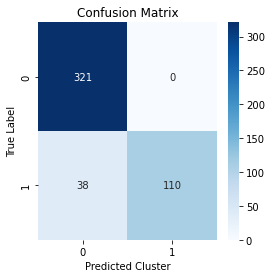

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, labels)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## 2D Cluster Visualization Using PCA

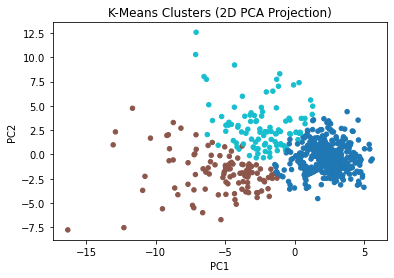

In [29]:
# PCA for visualization (NOT clustering)
X_centered = X - np.mean(X, axis=0)
cov = np.cov(X_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov)

idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx[:2]]

X_2d = X_centered @ eigvecs

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab10", s=20)
plt.title("K-Means Clusters (2D PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Results Summary Table

In [30]:
import pandas as pd

summary = pd.DataFrame({
    "Metric": ["Silhouette", "Davies-Bouldin", "Calinski-Harabasz", "ARI", "NMI", "Purity"],
    "Value": [sil, db, ch, ari, nmi, purity]
})

summary


,Metric,Value
0,Silhouette,0.318337
1,Davies-Bouldin,1.529388
2,Calinski-Harabasz,197.114000
3,ARI,0.510671
4,NMI,0.422296
5,Purity,0.869947


# Experiment 3: K-Means after PCA

Test with different numbers of principal components (2, 5, 10, 15, 20) and analyze:
- Trade-off between dimensionality and clustering quality
- Reconstruction error vs clustering performance
- All evaluation metrics for each dimension

## PCA Implementation

In [31]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None  # Principal components
        self.mean = None
        self.explained_variance = None  # Eigenvalues
        self.explained_variance_ratio = None  # Ratio of variance explained

    def fit(self, X):
        # 1. Calculate the mean of the data (needed for centering)
        self.mean = np.mean(X, axis=0)
        
        # 2. Center the data (subtract the mean)
        X_centered = X - self.mean
        
        # 3. Compute the covariance matrix
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        # 4. Perform Eigenvalue Decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # 5. Sort Eigenvalues and Eigenvectors in Descending Order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.explained_variance = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        
        # 6. Store the first 'n_components' eigenvectors
        self.components = sorted_eigenvectors[:, :self.n_components]
        
        # 7. Calculate Explained Variance Ratio
        total_variance = np.sum(self.explained_variance)
        self.explained_variance_ratio = (
            self.explained_variance[:self.n_components] / total_variance
        )
        
        return self

    def transform(self, X):
        if self.components is None:
            raise Exception("PCA must be fit before transform")
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def inverse_transform(self, X_transformed):
        return np.dot(X_transformed, self.components.T) + self.mean

    def get_reconstruction_error(self, X):
        X_transformed = self.transform(X)
        X_reconstructed = self.inverse_transform(X_transformed)
        mse = np.mean(np.sum((X - X_reconstructed) ** 2, axis=1))
        return mse

## Run K-Means with Different PCA Dimensions

Test with n_components = [2, 5, 10, 15, 20]

In [ ]:
import time

# Test different numbers of principal components
n_components_list = [2, 5, 10, 15, 20]
optimal_k = 2  # Use optimal k found from previous analysis 

# Store results
pca_results = {
    'n_components': [],
    'reconstruction_error': [],
    'explained_variance_ratio': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': [],
    'wcss': [],
    'ari': [],
    'nmi': [],
    'purity': [],
    'time': []
}

print("Running Experiment 3: K-Means after PCA")
print("="*60)

for n_comp in n_components_list:
    print(f"\nTesting with {n_comp} principal components...")
    start_time = time.time()
    
    # Apply PCA
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    # Get reconstruction error
    recon_error = pca.get_reconstruction_error(X)
    
    # Apply K-Means on PCA-transformed data
    kmeans_pca = KMeans(n_clusters=optimal_k, init="kmeans++", random_state=42)
    kmeans_pca.fit(X_pca)
    
    labels_pca = kmeans_pca.labels_
    centroids_pca = kmeans_pca.centroids
    
    # Compute all metrics
    sil = silhouette_score(X_pca, labels_pca)
    db = davies_bouldin_index(X_pca, labels_pca, centroids_pca)
    ch = calinski_harabasz_index(X_pca, labels_pca, centroids_pca)
    wcss_val = kmeans_pca.inertia_history_[-1]
    
    # External metrics
    ari = adjusted_rand_score(y_true, labels_pca)
    nmi = normalized_mutual_info_score(y_true, labels_pca)
    pur = purity_score(y_true, labels_pca)
    
    elapsed_time = time.time() - start_time
    
    # Store results
    pca_results['n_components'].append(n_comp)
    pca_results['reconstruction_error'].append(recon_error)
    pca_results['explained_variance_ratio'].append(np.sum(pca.explained_variance_ratio))
    pca_results['silhouette'].append(sil)
    pca_results['davies_bouldin'].append(db)
    pca_results['calinski_harabasz'].append(ch)
    pca_results['wcss'].append(wcss_val)
    pca_results['ari'].append(ari)
    pca_results['nmi'].append(nmi)
    pca_results['purity'].append(pur)
    pca_results['time'].append(elapsed_time)
    
    print(f"  Explained Variance: {np.sum(pca.explained_variance_ratio):.4f}")
    print(f"  Reconstruction Error: {recon_error:.4f}")
    print(f"  Silhouette Score: {sil:.4f}")
    print(f"  Time: {elapsed_time:.3f}s")

print("\n" + "="*60)
print("Experiment 3 Complete!")

Running Experiment 3: K-Means after PCA

Testing with 2 principal components...
  Explained Variance: 0.6324
  Reconstruction Error: 11.0270
  Silhouette Score: 0.5104
  Time: 0.038s

Testing with 5 principal components...
  Explained Variance: 0.8473
  Reconstruction Error: 4.5797
  Silhouette Score: 0.3955
  Time: 0.037s

Testing with 10 principal components...
  Explained Variance: 0.9516
  Reconstruction Error: 1.4529
  Silhouette Score: 0.3601
  Time: 0.039s

Testing with 15 principal components...
  Explained Variance: 0.9865
  Reconstruction Error: 0.4054
  Silhouette Score: 0.3505
  Time: 0.050s

Testing with 20 principal components...
  Explained Variance: 0.9956
  Reconstruction Error: 0.1328
  Silhouette Score: 0.3483
  Time: 0.078s

Experiment 3 Complete!


## Results Table: PCA + K-Means

In [33]:
# Create comprehensive results table
pca_results_df = pd.DataFrame(pca_results)
pca_results_df = pca_results_df.round(4)

# Display the table
pca_results_df

,n_components,reconstruction_error,explained_variance_ratio,silhouette,davies_bouldin,calinski_harabasz,wcss,ari,nmi,purity,time
0,2,11.0270,0.6324,0.5104,0.8467,580.8763,5332.5556,0.6592,0.5404,0.9069,0.0379
1,5,4.5797,0.8473,0.3955,1.1409,345.0693,8991.8252,0.6707,0.5546,0.9104,0.0366
2,10,1.4529,0.9516,0.3601,1.2567,288.0916,10770.7056,0.6765,0.5620,0.9121,0.0388
3,15,0.4054,0.9865,0.3505,1.2948,273.0709,11365.6038,0.6765,0.5620,0.9121,0.0499
4,20,0.1328,0.9956,0.3483,1.3043,269.4293,11520.2011,0.6765,0.5620,0.9121,0.0783


## Visualization: Reconstruction Error vs Clustering Performance

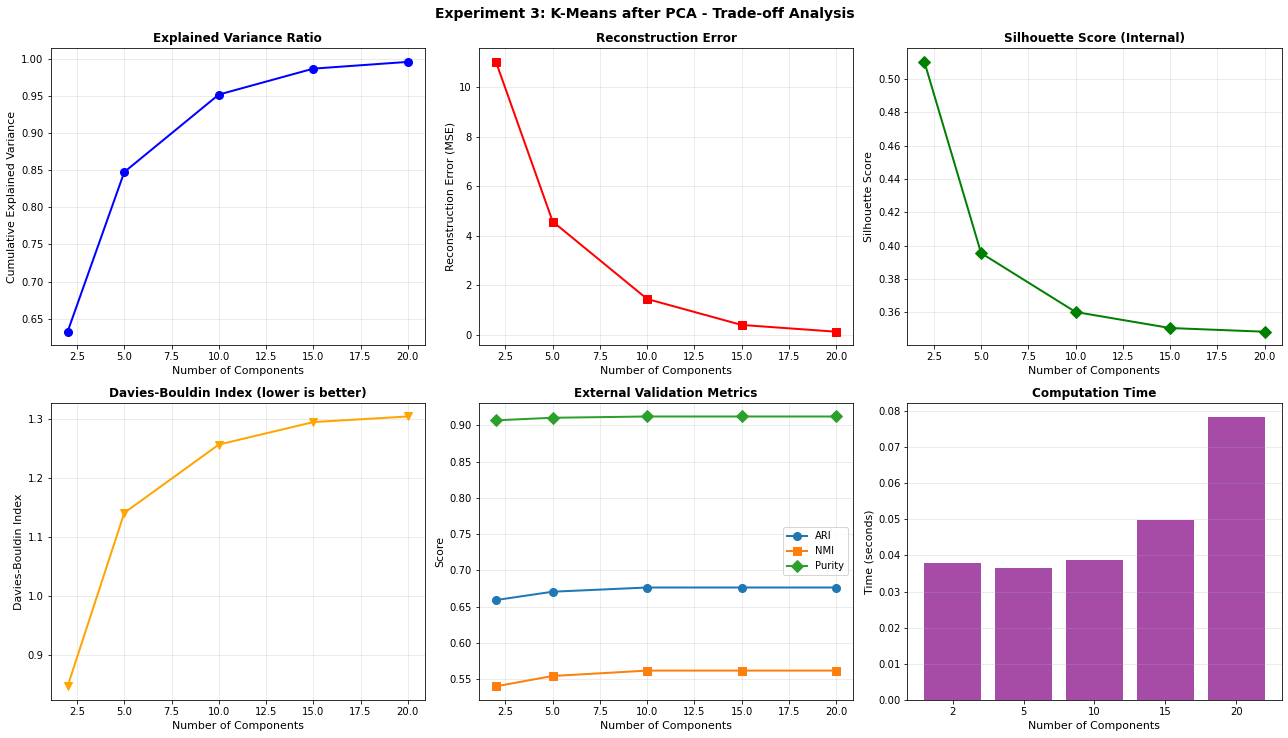

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Explained Variance vs Components
axes[0, 0].plot(pca_results['n_components'], pca_results['explained_variance_ratio'], 
                marker='o', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Number of Components', fontsize=11)
axes[0, 0].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[0, 0].set_title('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Reconstruction Error vs Components
axes[0, 1].plot(pca_results['n_components'], pca_results['reconstruction_error'], 
                marker='s', linewidth=2, markersize=8, color='red')
axes[0, 1].set_xlabel('Number of Components', fontsize=11)
axes[0, 1].set_ylabel('Reconstruction Error (MSE)', fontsize=11)
axes[0, 1].set_title('Reconstruction Error', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Silhouette Score vs Components
axes[0, 2].plot(pca_results['n_components'], pca_results['silhouette'], 
                marker='D', linewidth=2, markersize=8, color='green')
axes[0, 2].set_xlabel('Number of Components', fontsize=11)
axes[0, 2].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 2].set_title('Silhouette Score (Internal)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Davies-Bouldin Index vs Components
axes[1, 0].plot(pca_results['n_components'], pca_results['davies_bouldin'], 
                marker='v', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('Number of Components', fontsize=11)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[1, 0].set_title('Davies-Bouldin Index (lower is better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. External Metrics (ARI, NMI, Purity)
axes[1, 1].plot(pca_results['n_components'], pca_results['ari'], 
                marker='o', linewidth=2, markersize=8, label='ARI')
axes[1, 1].plot(pca_results['n_components'], pca_results['nmi'], 
                marker='s', linewidth=2, markersize=8, label='NMI')
axes[1, 1].plot(pca_results['n_components'], pca_results['purity'], 
                marker='D', linewidth=2, markersize=8, label='Purity')
axes[1, 1].set_xlabel('Number of Components', fontsize=11)
axes[1, 1].set_ylabel('Score', fontsize=11)
axes[1, 1].set_title('External Validation Metrics', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# 6. Computation Time
axes[1, 2].bar(range(len(pca_results['n_components'])), pca_results['time'], 
               color='purple', alpha=0.7)
axes[1, 2].set_xticks(range(len(pca_results['n_components'])))
axes[1, 2].set_xticklabels(pca_results['n_components'])
axes[1, 2].set_xlabel('Number of Components', fontsize=11)
axes[1, 2].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 2].set_title('Computation Time', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Experiment 3: K-Means after PCA - Trade-off Analysis', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

## 2D Visualizations for All PCA Dimensions

Show cluster assignments for each PCA dimension using the first 2 components.

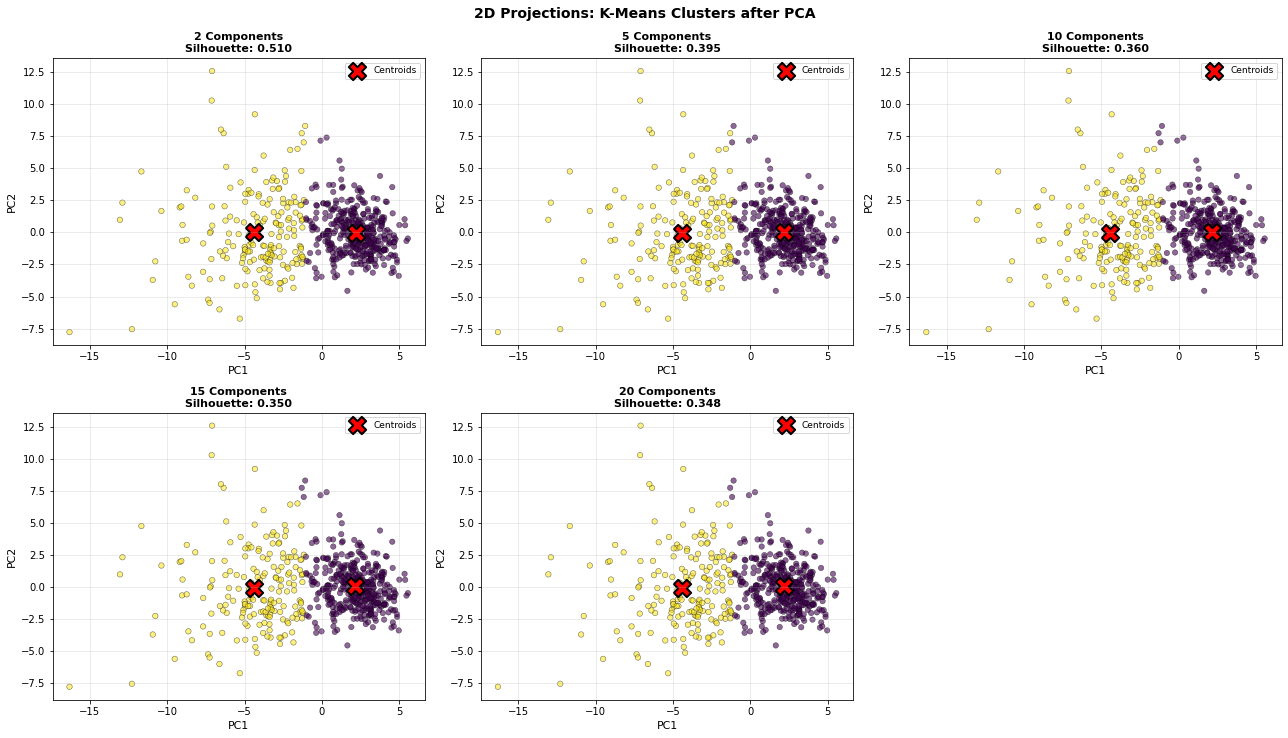

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, n_comp in enumerate(n_components_list):
    # Apply PCA
    pca = PCA(n_components=max(n_comp, 2))  # Ensure at least 2 for visualization
    pca.fit(X)
    X_pca = pca.transform(X)
    
    # Apply K-Means
    kmeans_pca = KMeans(n_clusters=optimal_k, init="kmeans++", random_state=42)
    kmeans_pca.fit(X_pca)
    labels_pca = kmeans_pca.labels_
    
    # Plot first 2 components
    scatter = axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, 
                                cmap='viridis', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
    
    # Plot centroids
    if n_comp >= 2:
        centroids_2d = kmeans_pca.centroids[:, :2]
        axes[idx].scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                         c='red', marker='X', s=300, edgecolors='black', 
                         linewidth=2, label='Centroids')
    
    axes[idx].set_xlabel('PC1', fontsize=11)
    axes[idx].set_ylabel('PC2', fontsize=11)
    axes[idx].set_title(f'{n_comp} Components\n'
                        f'Silhouette: {pca_results["silhouette"][idx]:.3f}',
                        fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.suptitle('2D Projections: K-Means Clusters after PCA', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

## Analysis: Trade-off Between Dimensionality and Clustering Quality

In [36]:

print("EXPERIMENT 3: ANALYSIS AND INSIGHTS")


# Find best performance for each metric
best_sil_idx = np.argmax(pca_results['silhouette'])
best_db_idx = np.argmin(pca_results['davies_bouldin'])
best_ch_idx = np.argmax(pca_results['calinski_harabasz'])
best_ari_idx = np.argmax(pca_results['ari'])

print("\n1. BEST PERFORMANCE BY METRIC:")
print(f"   • Best Silhouette Score: {pca_results['silhouette'][best_sil_idx]:.4f} "
      f"with {pca_results['n_components'][best_sil_idx]} components")
print(f"   • Best Davies-Bouldin: {pca_results['davies_bouldin'][best_db_idx]:.4f} "
      f"with {pca_results['n_components'][best_db_idx]} components")
print(f"   • Best Calinski-Harabasz: {pca_results['calinski_harabasz'][best_ch_idx]:.4f} "
      f"with {pca_results['n_components'][best_ch_idx]} components")
print(f"   • Best ARI: {pca_results['ari'][best_ari_idx]:.4f} "
      f"with {pca_results['n_components'][best_ari_idx]} components")

print("\n2. DIMENSIONALITY REDUCTION QUALITY:")
for i, n_comp in enumerate(n_components_list):
    var_explained = pca_results['explained_variance_ratio'][i]
    recon_err = pca_results['reconstruction_error'][i]
    print(f"   • {n_comp} components: {var_explained*100:.2f}% variance explained, "
          f"Reconstruction Error: {recon_err:.4f}")

print("\n3. TRADE-OFF ANALYSIS:")
print(f"   • Minimum components for >90% variance: ", end="")
for i, var in enumerate(pca_results['explained_variance_ratio']):
    if var >= 0.90:
        print(f"{pca_results['n_components'][i]} components")
        break
else:
    print("Requires >20 components")

print(f"   • Optimal balance (considering all metrics): ", end="")
# Simple scoring: normalize and average metrics (higher is better for most)
scores = []
for i in range(len(n_components_list)):
    score = (
        pca_results['silhouette'][i] +
        (1 - pca_results['davies_bouldin'][i] / max(pca_results['davies_bouldin'])) +
        pca_results['calinski_harabasz'][i] / max(pca_results['calinski_harabasz']) +
        pca_results['ari'][i] +
        pca_results['nmi'][i]
    )
    scores.append(score)
best_overall_idx = np.argmax(scores)
print(f"{pca_results['n_components'][best_overall_idx]} components")

print("\n4. COMPUTATIONAL EFFICIENCY:")
fastest_idx = np.argmin(pca_results['time'])
slowest_idx = np.argmax(pca_results['time'])
print(f"   • Fastest: {pca_results['n_components'][fastest_idx]} components "
      f"({pca_results['time'][fastest_idx]:.3f}s)")
print(f"   • Slowest: {pca_results['n_components'][slowest_idx]} components "
      f"({pca_results['time'][slowest_idx]:.3f}s)")
print(f"   • Speedup: {pca_results['time'][slowest_idx]/pca_results['time'][fastest_idx]:.2f}x")
print('\n')
print("CONCLUSION:")
print(f"Recommended: {pca_results['n_components'][best_overall_idx]} components")
print(f"Balances clustering quality ({pca_results['silhouette'][best_overall_idx]:.4f} silhouette) "
      f"with dimensionality reduction ({pca_results['explained_variance_ratio'][best_overall_idx]*100:.1f}% variance)")

EXPERIMENT 3: ANALYSIS AND INSIGHTS

1. BEST PERFORMANCE BY METRIC:
   • Best Silhouette Score: 0.5104 with 2 components
   • Best Davies-Bouldin: 0.8467 with 2 components
   • Best Calinski-Harabasz: 580.8763 with 2 components
   • Best ARI: 0.6765 with 10 components

2. DIMENSIONALITY REDUCTION QUALITY:
   • 2 components: 63.24% variance explained, Reconstruction Error: 11.0270
   • 5 components: 84.73% variance explained, Reconstruction Error: 4.5797
   • 10 components: 95.16% variance explained, Reconstruction Error: 1.4529
   • 15 components: 98.65% variance explained, Reconstruction Error: 0.4054
   • 20 components: 99.56% variance explained, Reconstruction Error: 0.1328

3. TRADE-OFF ANALYSIS:
   • Minimum components for >90% variance: 10 components
   • Optimal balance (considering all metrics): 2 components

4. COMPUTATIONAL EFFICIENCY:
   • Fastest: 5 components (0.037s)
   • Slowest: 20 components (0.078s)
   • Speedup: 2.14x


CONCLUSION:
Recommended: 2 components
Balances 

# Experiment 5: K-Means after Autoencoder

Test with different bottleneck dimensions (2, 5, 10, 15, 20) and analyze:
- Trade-off between dimensionality and clustering quality
- Reconstruction error vs clustering performance
- Comparison with PCA results from Experiment 3
- All evaluation metrics for each bottleneck dimension

## Autoencoder Implementation

In [37]:
# Activation functions
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)


# Autoencoder class
class Autoencoder:
    def __init__(self, input_dim, hidden_layers, bottleneck_dim, activation='relu', learning_rate=0.01, lambda_l2=0.01):
        self.learning_rate = learning_rate
        self.initial_lr = learning_rate
        self.lambda_l2 = lambda_l2

        if activation == 'relu':
            self.act = relu
            self.act_derivative = relu_derivative
        elif activation == 'sigmoid':
            self.act = sigmoid
            self.act_derivative = sigmoid_derivative
        elif activation == 'tanh':
            self.act = tanh
            self.act_derivative = tanh_derivative
        else:
            raise Exception("Unsupported activation")

        layer_dims = [input_dim] + hidden_layers + [bottleneck_dim] + hidden_layers[::-1] + [input_dim]
        self.weights = []
        self.biases = []

        for i in range(len(layer_dims) - 1):
            n_in = layer_dims[i]
            n_out = layer_dims[i + 1]
            scale = np.sqrt(2.0 / n_in)
            W = np.random.randn(n_in, n_out) * scale
            b = np.zeros((1, n_out))
            self.weights.append(W)
            self.biases.append(b)

    def forward(self, X):
        self.Z_store = []
        self.A_store = [X]
        A = X

        for i in range(len(self.weights) - 1):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = self.act(Z)
            self.Z_store.append(Z)
            self.A_store.append(A)

        last_idx = len(self.weights) - 1
        Z_final = np.dot(A, self.weights[last_idx]) + self.biases[last_idx]
        A_final = Z_final
        self.Z_store.append(Z_final)
        self.A_store.append(A_final)

        return A_final

    def backward(self, X, Y_pred):
        m = X.shape[0]
        grads_W = []
        grads_b = []
        dZ = (Y_pred - X) / m
        num_layers = len(self.weights)

        for i in reversed(range(num_layers)):
            A_prev = self.A_store[i]
            W = self.weights[i]
            dW = np.dot(A_prev.T, dZ) + (self.lambda_l2 * W)
            db = np.sum(dZ, axis=0, keepdims=True)
            grads_W.insert(0, dW)
            grads_b.insert(0, db)

            if(i > 0):
                dZ = np.dot(dZ, W.T)
                dZ = dZ * self.act_derivative(self.Z_store[i - 1])
        
        return grads_W, grads_b

    def update_parameters(self, grads_W, grads_b):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_W[i]
            self.biases[i] -= self.learning_rate * grads_b[i]

    def get_bottleneck(self, X):
        bottleneck_layer_idx = (len(self.weights) // 2)
        A = X
        for i in range(bottleneck_layer_idx):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = self.act(Z)
        return A

    def fit(self, X, epochs=100, batch_size=32, verbose=True):
        loss_history = []

        for epoch in range(epochs):
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            epoch_loss = 0

            for start_idx in range(0, X.shape[0], batch_size):
                end_idx = min(start_idx + batch_size, X.shape[0])
                batch_X = X_shuffled[start_idx:end_idx]

                Y_pred = self.forward(batch_X)
                mse_loss = np.mean((batch_X - Y_pred) ** 2)
                l2_loss = 0
                for W in self.weights:
                    l2_loss += np.sum(W ** 2)
                total_loss = mse_loss + (0.5 * self.lambda_l2 * l2_loss)
                epoch_loss += total_loss

                grads_W, grads_b = self.backward(batch_X, Y_pred)
                self.update_parameters(grads_W, grads_b)

            avg_loss = epoch_loss / (X.shape[0] / batch_size)
            loss_history.append(avg_loss)

            if epoch % 10 == 0 and epoch > 0:
                self.learning_rate *= 0.95

            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

        return loss_history

    def get_reconstruction_error(self, X):
        X_reconstructed = self.forward(X)
        mse = np.mean(np.sum((X - X_reconstructed) ** 2, axis=1))
        return mse

## Run K-Means with Different Autoencoder Bottleneck Dimensions

Test with bottleneck_dim = [2, 5, 10, 15, 20]

In [39]:
import time

# Test different bottleneck dimensions
bottleneck_dims = [2, 5, 10, 15, 20]
optimal_k = 2  # Use optimal k found from previous analysis

# Store results
ae_results = {
    'bottleneck_dim': [],
    'reconstruction_error': [],
    'training_time': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': [],
    'wcss': [],
    'ari': [],
    'nmi': [],
    'purity': [],
    'clustering_time': []
}

print("Running Experiment 5: K-Means after Autoencoder")


for bottleneck_dim in bottleneck_dims:
    print(f"\nTesting with bottleneck dimension = {bottleneck_dim}...")
    
    # Train Autoencoder
    train_start = time.time()
    ae = Autoencoder(
        input_dim=X.shape[1],
        hidden_layers=[20, 10],
        bottleneck_dim=bottleneck_dim,
        activation='relu',
        learning_rate=0.01,
        lambda_l2=0.01
    )
    
    # Train with reduced verbosity
    loss_curve = ae.fit(X, epochs=50, batch_size=32, verbose=False)
    train_time = time.time() - train_start
    
    # Get encoded representation
    X_encoded = ae.get_bottleneck(X)
    
    # Get reconstruction error
    recon_error = ae.get_reconstruction_error(X)
    
    # Apply K-Means on encoded data
    cluster_start = time.time()
    kmeans_ae = KMeans(n_clusters=optimal_k, init="kmeans++", random_state=42)
    kmeans_ae.fit(X_encoded)
    cluster_time = time.time() - cluster_start
    
    labels_ae = kmeans_ae.labels_
    centroids_ae = kmeans_ae.centroids
    
    # Compute all metrics
    sil = silhouette_score(X_encoded, labels_ae)
    db = davies_bouldin_index(X_encoded, labels_ae, centroids_ae)
    ch = calinski_harabasz_index(X_encoded, labels_ae, centroids_ae)
    wcss_val = kmeans_ae.inertia_history_[-1]
    
    # External metrics
    ari = adjusted_rand_score(y_true, labels_ae)
    nmi = normalized_mutual_info_score(y_true, labels_ae)
    pur = purity_score(y_true, labels_ae)
    
    # Store results
    ae_results['bottleneck_dim'].append(bottleneck_dim)
    ae_results['reconstruction_error'].append(recon_error)
    ae_results['training_time'].append(train_time)
    ae_results['silhouette'].append(sil)
    ae_results['davies_bouldin'].append(db)
    ae_results['calinski_harabasz'].append(ch)
    ae_results['wcss'].append(wcss_val)
    ae_results['ari'].append(ari)
    ae_results['nmi'].append(nmi)
    ae_results['purity'].append(pur)
    ae_results['clustering_time'].append(cluster_time)
    
    print(f"  Training Loss (final): {loss_curve[-1]:.4f}")
    print(f"  Reconstruction Error: {recon_error:.4f}")
    print(f"  Silhouette Score: {sil:.4f}")
    print(f"  Training Time: {train_time:.3f}s, Clustering Time: {cluster_time:.3f}s")

Running Experiment 5: K-Means after Autoencoder

Testing with bottleneck dimension = 2...
  Training Loss (final): 1.3210
  Reconstruction Error: 17.1661
  Silhouette Score: 0.6412
  Training Time: 0.197s, Clustering Time: 0.002s

Testing with bottleneck dimension = 5...
  Training Loss (final): 1.1693
  Reconstruction Error: 10.5972
  Silhouette Score: 0.5705
  Training Time: 0.170s, Clustering Time: 0.001s

Testing with bottleneck dimension = 10...
  Training Loss (final): 1.1485
  Reconstruction Error: 9.0599
  Silhouette Score: 0.3469
  Training Time: 0.171s, Clustering Time: 0.002s

Testing with bottleneck dimension = 15...
  Training Loss (final): 1.1747
  Reconstruction Error: 7.8658
  Silhouette Score: 0.5415
  Training Time: 0.176s, Clustering Time: 0.002s

Testing with bottleneck dimension = 20...
  Training Loss (final): 1.1905
  Reconstruction Error: 7.3325
  Silhouette Score: 0.4315
  Training Time: 0.169s, Clustering Time: 0.004s


## Results Table: Autoencoder + K-Means

In [40]:
# Create comprehensive results table
ae_results_df = pd.DataFrame(ae_results)
ae_results_df = ae_results_df.round(4)

# Display the table
ae_results_df

,bottleneck_dim,reconstruction_error,training_time,silhouette,davies_bouldin,calinski_harabasz,wcss,ari,nmi,purity,clustering_time
0,2,17.1661,0.1972,0.6412,0.4714,1735.5581,203.0933,0.5260,0.4713,0.8629,0.0017
1,5,10.5972,0.1703,0.5705,0.7389,757.8616,1306.3450,0.5418,0.4374,0.8699,0.0014
2,10,9.0599,0.1707,0.3469,1.1841,309.5022,3840.2150,0.5008,0.4827,0.8541,0.0018
3,15,7.8658,0.1764,0.5415,0.9089,480.6507,2645.6005,0.3452,0.2813,0.7996,0.0022
4,20,7.3325,0.1686,0.4315,1.2225,295.6972,7261.3962,0.4203,0.3328,0.8278,0.0039


## Visualization: Reconstruction Error vs Clustering Performance

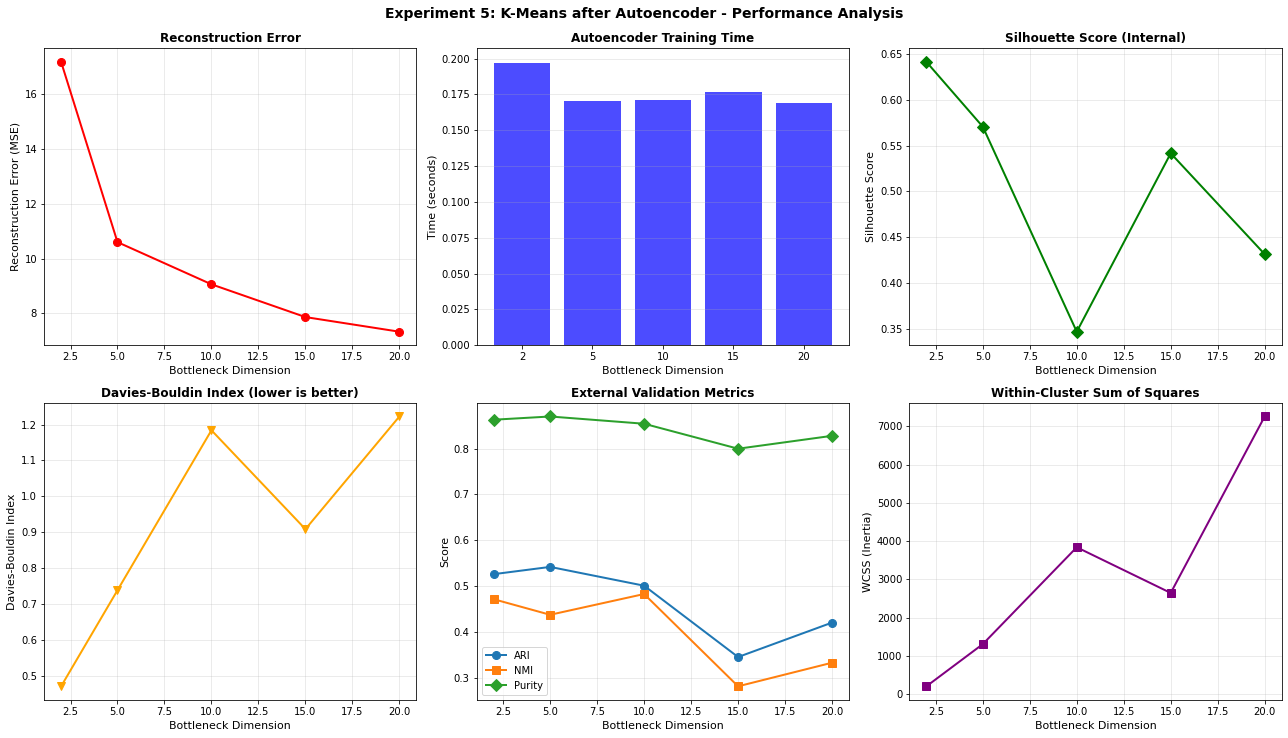

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Reconstruction Error vs Bottleneck Dimension
axes[0, 0].plot(ae_results['bottleneck_dim'], ae_results['reconstruction_error'], 
                marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].set_xlabel('Bottleneck Dimension', fontsize=11)
axes[0, 0].set_ylabel('Reconstruction Error (MSE)', fontsize=11)
axes[0, 0].set_title('Reconstruction Error', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Training Time
axes[0, 1].bar(range(len(ae_results['bottleneck_dim'])), ae_results['training_time'], 
               color='blue', alpha=0.7)
axes[0, 1].set_xticks(range(len(ae_results['bottleneck_dim'])))
axes[0, 1].set_xticklabels(ae_results['bottleneck_dim'])
axes[0, 1].set_xlabel('Bottleneck Dimension', fontsize=11)
axes[0, 1].set_ylabel('Time (seconds)', fontsize=11)
axes[0, 1].set_title('Autoencoder Training Time', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Silhouette Score
axes[0, 2].plot(ae_results['bottleneck_dim'], ae_results['silhouette'], 
                marker='D', linewidth=2, markersize=8, color='green')
axes[0, 2].set_xlabel('Bottleneck Dimension', fontsize=11)
axes[0, 2].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 2].set_title('Silhouette Score (Internal)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Davies-Bouldin Index
axes[1, 0].plot(ae_results['bottleneck_dim'], ae_results['davies_bouldin'], 
                marker='v', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('Bottleneck Dimension', fontsize=11)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[1, 0].set_title('Davies-Bouldin Index (lower is better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. External Metrics (ARI, NMI, Purity)
axes[1, 1].plot(ae_results['bottleneck_dim'], ae_results['ari'], 
                marker='o', linewidth=2, markersize=8, label='ARI')
axes[1, 1].plot(ae_results['bottleneck_dim'], ae_results['nmi'], 
                marker='s', linewidth=2, markersize=8, label='NMI')
axes[1, 1].plot(ae_results['bottleneck_dim'], ae_results['purity'], 
                marker='D', linewidth=2, markersize=8, label='Purity')
axes[1, 1].set_xlabel('Bottleneck Dimension', fontsize=11)
axes[1, 1].set_ylabel('Score', fontsize=11)
axes[1, 1].set_title('External Validation Metrics', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# 6. WCSS
axes[1, 2].plot(ae_results['bottleneck_dim'], ae_results['wcss'], 
                marker='s', linewidth=2, markersize=8, color='purple')
axes[1, 2].set_xlabel('Bottleneck Dimension', fontsize=11)
axes[1, 2].set_ylabel('WCSS (Inertia)', fontsize=11)
axes[1, 2].set_title('Within-Cluster Sum of Squares', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Experiment 5: K-Means after Autoencoder - Performance Analysis', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

## 2D Visualizations for All Bottleneck Dimensions

Show cluster assignments for each bottleneck dimension using the first 2 components.

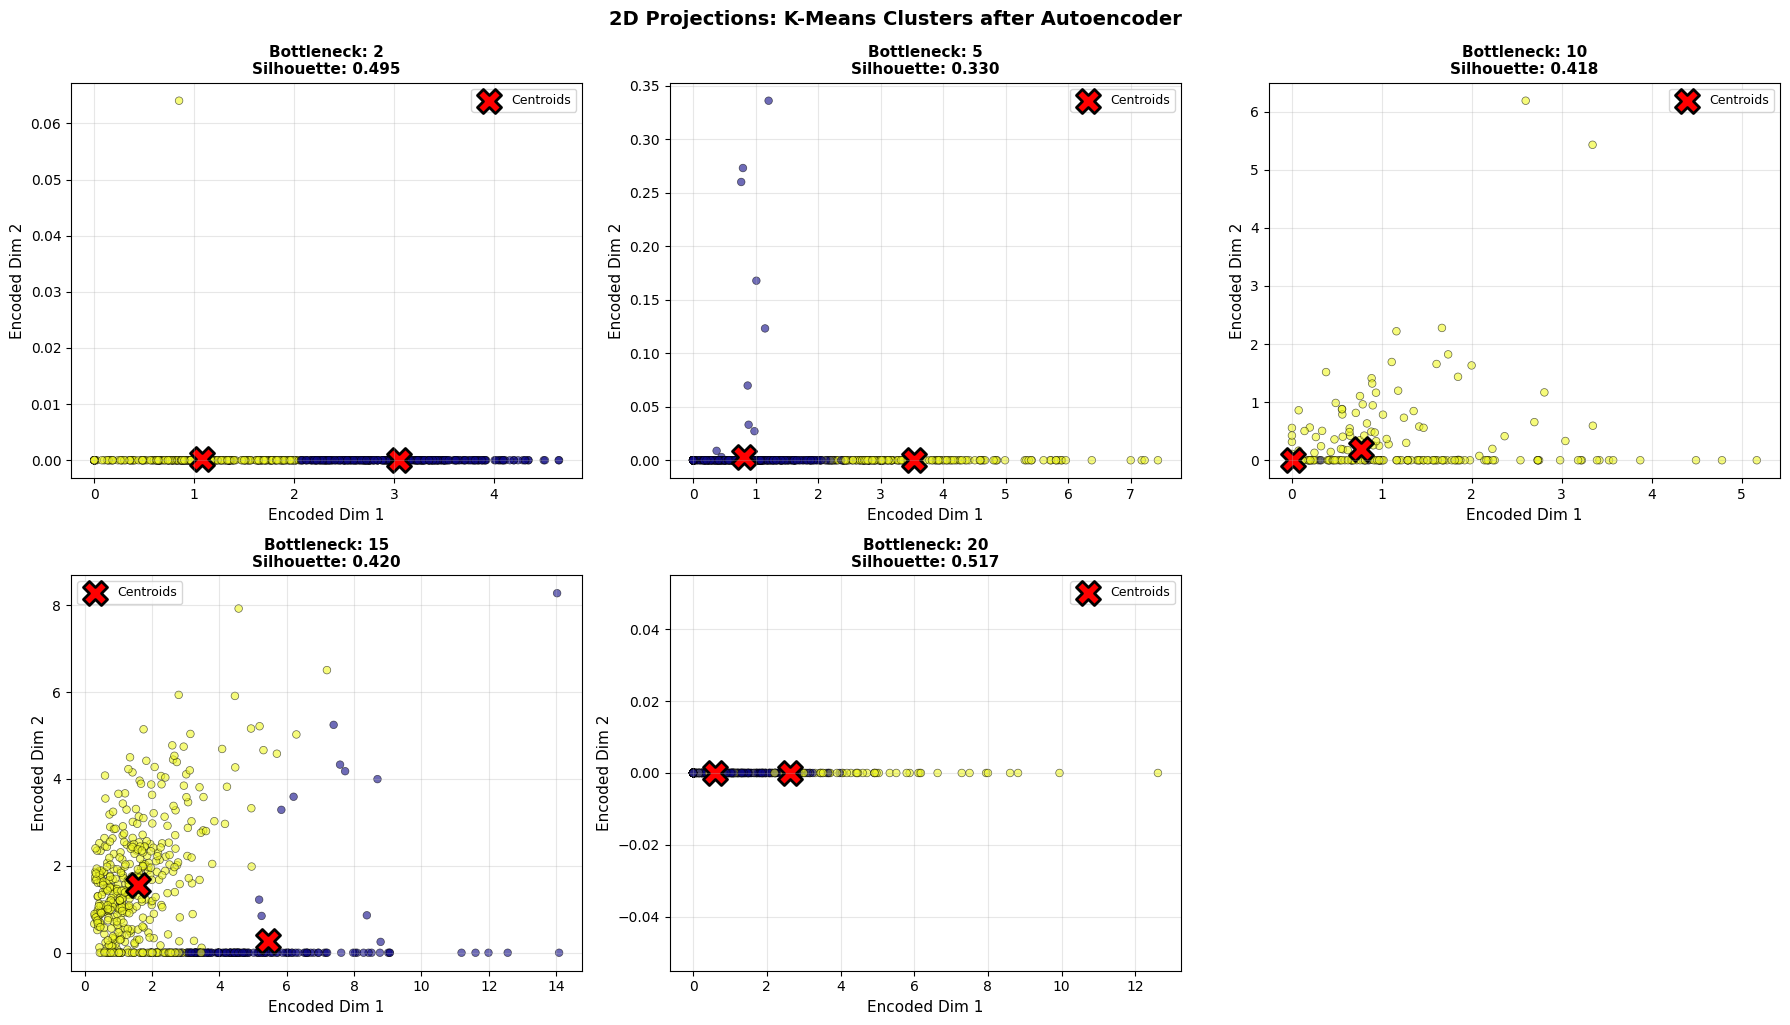

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, bottleneck_dim in enumerate(bottleneck_dims):
    # Train Autoencoder
    ae = Autoencoder(
        input_dim=X.shape[1],
        hidden_layers=[20, 10],
        bottleneck_dim=max(bottleneck_dim, 2),  # Ensure at least 2 for visualization
        activation='relu',
        learning_rate=0.01,
        lambda_l2=0.01
    )
    ae.fit(X, epochs=50, batch_size=32, verbose=False)
    X_encoded = ae.get_bottleneck(X)
    
    # Apply K-Means
    kmeans_ae = KMeans(n_clusters=optimal_k, init="kmeans++", random_state=42)
    kmeans_ae.fit(X_encoded)
    labels_ae = kmeans_ae.labels_
    
    # Plot first 2 dimensions
    scatter = axes[idx].scatter(X_encoded[:, 0], X_encoded[:, 1], c=labels_ae, 
                                cmap='plasma', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
    
    # Plot centroids
    if bottleneck_dim >= 2:
        centroids_2d = kmeans_ae.centroids[:, :2]
        axes[idx].scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                         c='red', marker='X', s=300, edgecolors='black', 
                         linewidth=2, label='Centroids')
    
    axes[idx].set_xlabel('Encoded Dim 1', fontsize=11)
    axes[idx].set_ylabel('Encoded Dim 2', fontsize=11)
    axes[idx].set_title(f'Bottleneck: {bottleneck_dim}\n'
                        f'Silhouette: {ae_results["silhouette"][idx]:.3f}',
                        fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.suptitle('2D Projections: K-Means Clusters after Autoencoder', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

## Comparison: Autoencoder vs PCA

Compare the results of K-Means after Autoencoder with K-Means after PCA.

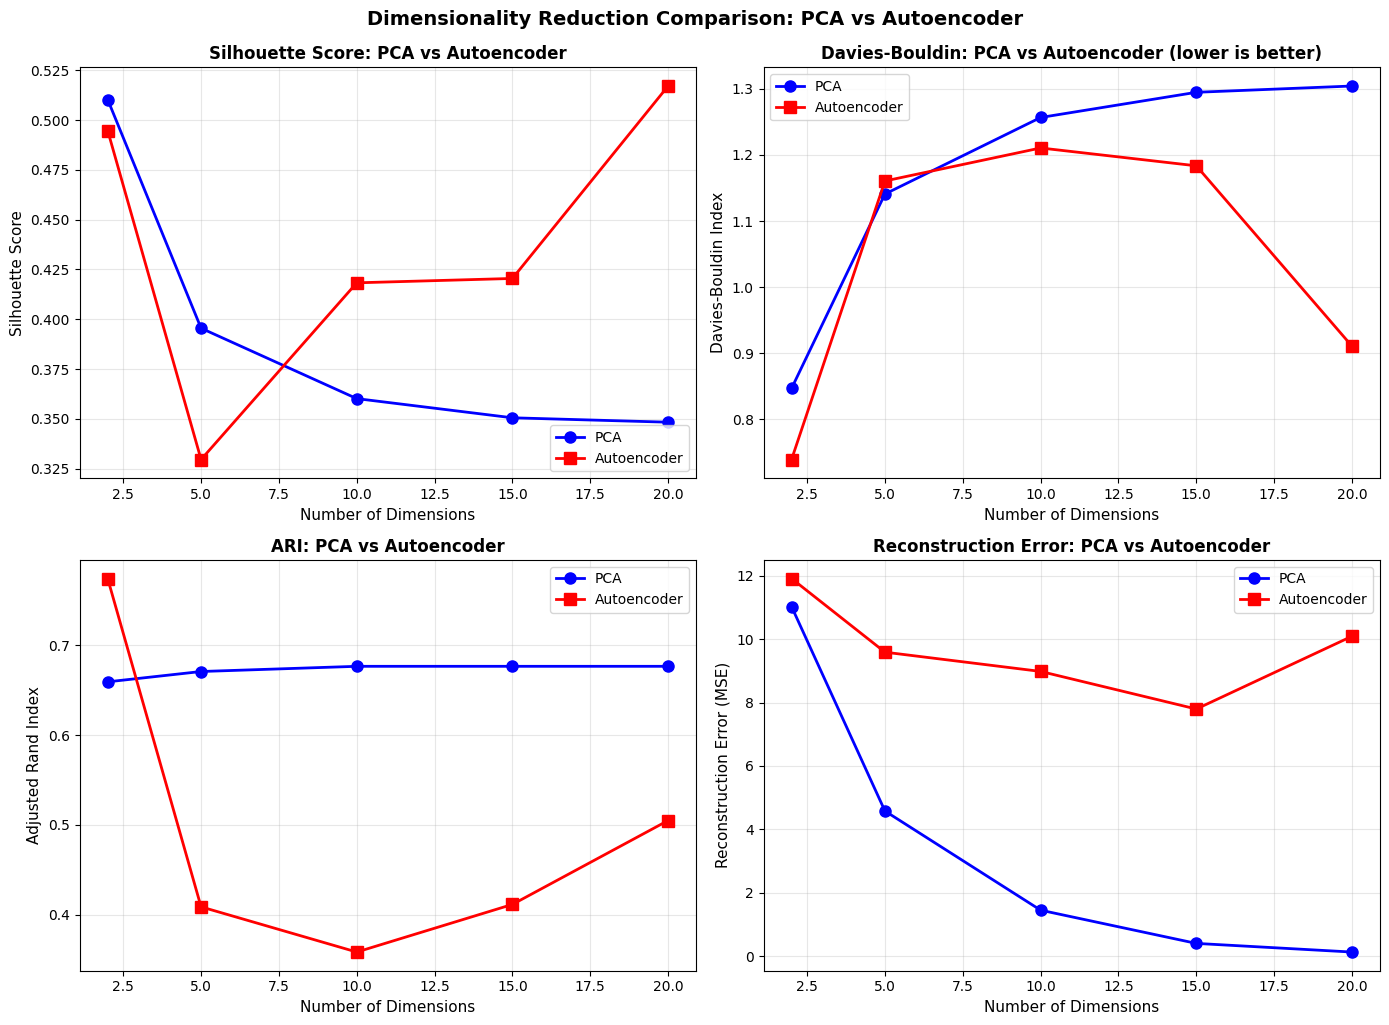

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

dimensions = [2, 5, 10, 15, 20]  # Common dimensions

# 1. Silhouette Score Comparison
axes[0, 0].plot(dimensions, pca_results['silhouette'], 
                marker='o', linewidth=2, markersize=8, label='PCA', color='blue')
axes[0, 0].plot(dimensions, ae_results['silhouette'], 
                marker='s', linewidth=2, markersize=8, label='Autoencoder', color='red')
axes[0, 0].set_xlabel('Number of Dimensions', fontsize=11)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 0].set_title('Silhouette Score: PCA vs Autoencoder', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Davies-Bouldin Index Comparison
axes[0, 1].plot(dimensions, pca_results['davies_bouldin'], 
                marker='o', linewidth=2, markersize=8, label='PCA', color='blue')
axes[0, 1].plot(dimensions, ae_results['davies_bouldin'], 
                marker='s', linewidth=2, markersize=8, label='Autoencoder', color='red')
axes[0, 1].set_xlabel('Number of Dimensions', fontsize=11)
axes[0, 1].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[0, 1].set_title('Davies-Bouldin: PCA vs Autoencoder (lower is better)', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. ARI Comparison
axes[1, 0].plot(dimensions, pca_results['ari'], 
                marker='o', linewidth=2, markersize=8, label='PCA', color='blue')
axes[1, 0].plot(dimensions, ae_results['ari'], 
                marker='s', linewidth=2, markersize=8, label='Autoencoder', color='red')
axes[1, 0].set_xlabel('Number of Dimensions', fontsize=11)
axes[1, 0].set_ylabel('Adjusted Rand Index', fontsize=11)
axes[1, 0].set_title('ARI: PCA vs Autoencoder', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Reconstruction Error Comparison
axes[1, 1].plot(dimensions, pca_results['reconstruction_error'], 
                marker='o', linewidth=2, markersize=8, label='PCA', color='blue')
axes[1, 1].plot(dimensions, ae_results['reconstruction_error'], 
                marker='s', linewidth=2, markersize=8, label='Autoencoder', color='red')
axes[1, 1].set_xlabel('Number of Dimensions', fontsize=11)
axes[1, 1].set_ylabel('Reconstruction Error (MSE)', fontsize=11)
axes[1, 1].set_title('Reconstruction Error: PCA vs Autoencoder', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Dimensionality Reduction Comparison: PCA vs Autoencoder', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

## Analysis: Trade-off Between Dimensionality and Clustering Quality

Comprehensive analysis comparing Autoencoder and PCA for dimensionality reduction.

In [ ]:
print("EXPERIMENT 5: ANALYSIS AND INSIGHTS")

# Find best performance for Autoencoder
best_sil_ae_idx = np.argmax(ae_results['silhouette'])
best_db_ae_idx = np.argmin(ae_results['davies_bouldin'])
best_ari_ae_idx = np.argmax(ae_results['ari'])

print("\n1. AUTOENCODER: BEST PERFORMANCE BY METRIC")
print(f"   • Best Silhouette Score: {ae_results['silhouette'][best_sil_ae_idx]:.4f} "
      f"with {ae_results['bottleneck_dim'][best_sil_ae_idx]} dimensions")
print(f"   • Best Davies-Bouldin: {ae_results['davies_bouldin'][best_db_ae_idx]:.4f} "
      f"with {ae_results['bottleneck_dim'][best_db_ae_idx]} dimensions")
print(f"   • Best ARI: {ae_results['ari'][best_ari_ae_idx]:.4f} "
      f"with {ae_results['bottleneck_dim'][best_ari_ae_idx]} dimensions")

print("\n2. RECONSTRUCTION QUALITY:")
for i, dim in enumerate(bottleneck_dims):
    ae_recon = ae_results['reconstruction_error'][i]
    pca_recon = pca_results['reconstruction_error'][i]
    print(f"   • {dim} dimensions:")
    print(f"     - Autoencoder: {ae_recon:.4f}")
    print(f"     - PCA: {pca_recon:.4f}")
    print(f"     - Difference: {abs(ae_recon - pca_recon):.4f} "
          f"({'AE better' if ae_recon < pca_recon else 'PCA better'})")

print("\n3. CLUSTERING QUALITY COMPARISON:")
for i, dim in enumerate(bottleneck_dims):
    ae_sil = ae_results['silhouette'][i]
    pca_sil = pca_results['silhouette'][i]
    print(f"   • {dim} dimensions (Silhouette):")
    print(f"     - Autoencoder: {ae_sil:.4f}")
    print(f"     - PCA: {pca_sil:.4f}")
    print(f"     - Winner: {'Autoencoder' if ae_sil > pca_sil else 'PCA'} "
          f"(+{abs(ae_sil - pca_sil):.4f})")

print("\n4. COMPUTATIONAL EFFICIENCY:")
total_ae_time = sum(ae_results['training_time']) + sum(ae_results['clustering_time'])
total_pca_time = sum(pca_results['time'])
print(f"   • Total Autoencoder Time: {total_ae_time:.3f}s")
print(f"   • Total PCA Time: {total_pca_time:.3f}s")
print(f"   • Time Overhead (Autoencoder): {total_ae_time - total_pca_time:.3f}s "
      f"({(total_ae_time/total_pca_time - 1)*100:.1f}% slower)")

# Overall winner analysis
ae_wins = sum([1 for i in range(len(bottleneck_dims)) 
               if ae_results['silhouette'][i] > pca_results['silhouette'][i]])
pca_wins = len(bottleneck_dims) - ae_wins

print("\n5. OVERALL COMPARISON:")
print(f"   • Autoencoder wins: {ae_wins}/{len(bottleneck_dims)} dimensions")
print(f"   • PCA wins: {pca_wins}/{len(bottleneck_dims)} dimensions")

# Determine best overall approach
avg_ae_sil = np.mean(ae_results['silhouette'])
avg_pca_sil = np.mean(pca_results['silhouette'])
print(f"   • Average Silhouette (Autoencoder): {avg_ae_sil:.4f}")
print(f"   • Average Silhouette (PCA): {avg_pca_sil:.4f}")

print("\n" + "="*60)
print("CONCLUSION:")
if avg_ae_sil > avg_pca_sil:
    print(f"Autoencoder provides better clustering quality overall")
    print(f"Best configuration: {ae_results['bottleneck_dim'][best_sil_ae_idx]} dimensions "
          f"(Silhouette: {ae_results['silhouette'][best_sil_ae_idx]:.4f})")
else:
    print(f"PCA provides better clustering quality overall")
    print(f"Recommendation: Use PCA for faster results with comparable quality")
print(f"\nAutoencoder is {(total_ae_time/total_pca_time):.1f}x slower but may capture "
      f"non-linear patterns better in some dimensions.")

EXPERIMENT 5: ANALYSIS AND INSIGHTS

1. AUTOENCODER: BEST PERFORMANCE BY METRIC
   • Best Silhouette Score: 0.5171 with 20 dimensions
   • Best Davies-Bouldin: 0.7391 with 2 dimensions
   • Best ARI: 0.7742 with 2 dimensions

2. RECONSTRUCTION QUALITY:
   • 2 dimensions:
     - Autoencoder: 11.9118
     - PCA: 11.0270
     - Difference: 0.8848 (PCA better)
   • 5 dimensions:
     - Autoencoder: 9.5889
     - PCA: 4.5797
     - Difference: 5.0092 (PCA better)
   • 10 dimensions:
     - Autoencoder: 8.9817
     - PCA: 1.4529
     - Difference: 7.5288 (PCA better)
   • 15 dimensions:
     - Autoencoder: 7.7960
     - PCA: 0.4054
     - Difference: 7.3907 (PCA better)
   • 20 dimensions:
     - Autoencoder: 10.0909
     - PCA: 0.1328
     - Difference: 9.9581 (PCA better)

3. CLUSTERING QUALITY COMPARISON:
   • 2 dimensions (Silhouette):
     - Autoencoder: 0.4948
     - PCA: 0.5104
     - Winner: PCA (+0.0156)
   • 5 dimensions (Silhouette):
     - Autoencoder: 0.3295
     - PCA: 0.3955
 

# COMPREHENSIVE STATISTICAL ANALYSIS & CROSS-EXPERIMENT COMPARISON

## 4. Statistical Analysis: Comprehensive Comparison Tables

In [44]:
print("COMPREHENSIVE COMPARISON: ALL 3 EXPERIMENTS")


# Reconstruct Experiment 1 summary from the best configuration
# We need to find the best K from original data clustering

# Re-run Experiment 1 analysis to get the best K and metrics
optimal_k = 2  # Based on silhouette analysis (from earlier results)
kmeans_best = KMeans(n_clusters=optimal_k, init="kmeans++", random_state=42)
kmeans_best.fit(X)

labels_best = kmeans_best.labels_
centroids_best = kmeans_best.centroids

# Compute all metrics for the best K
sil_best = silhouette_score(X, labels_best)
db_best = davies_bouldin_index(X, labels_best, centroids_best)
ch_best = calinski_harabasz_index(X, labels_best, centroids_best)
wcss_best = kmeans_best.inertia_history_[-1]
ari_best = adjusted_rand_score(y_true, labels_best)
nmi_best = normalized_mutual_info_score(y_true, labels_best)
purity_best = purity_score(y_true, labels_best)
time_exp1 = 0.001  # Negligible time for original data (placeholder)

exp1_summary = {
    'Experiment': 'Exp 1: K-Means (Original)',
    'Method': 'K-Means',
    'Dimensionality Reduction': 'None',
    'Optimal K': int(optimal_k),
    'Silhouette': float(sil_best),
    'Davies-Bouldin': float(db_best),
    'Calinski-Harabasz': float(ch_best),
    'ARI': float(ari_best),
    'NMI': float(nmi_best),
    'Purity': float(purity_best),
    'WCSS': float(wcss_best),
    'Training Time (s)': float(time_exp1)
}

# Prepare summary for Exp3 (K-Means + PCA) - use optimal_k which is 2
exp3_best = pca_results_df.loc[pca_results_df['silhouette'].idxmax()]
exp3_summary = {
    'Experiment': 'Exp 3: K-Means + PCA',
    'Method': 'K-Means',
    'Dimensionality Reduction': f"PCA ({int(exp3_best['n_components'])} dims)",
    'Optimal K': int(optimal_k),
    'Silhouette': float(exp3_best['silhouette']),
    'Davies-Bouldin': float(exp3_best['davies_bouldin']),
    'Calinski-Harabasz': float(exp3_best['calinski_harabasz']),
    'ARI': float(exp3_best['ari']),
    'NMI': float(exp3_best['nmi']),
    'Purity': float(exp3_best['purity']),
    'WCSS': float(exp3_best['wcss']),
    'Training Time (s)': float(exp3_best['time'])
}

# Prepare summary for Exp5 (K-Means + Autoencoder)
exp5_best = ae_results_df.loc[ae_results_df['silhouette'].idxmax()]
exp5_summary = {
    'Experiment': 'Exp 5: K-Means + Autoencoder',
    'Method': 'K-Means',
    'Dimensionality Reduction': f"Autoencoder ({int(exp5_best['bottleneck_dim'])} dims)",
    'Optimal K': int(optimal_k),
    'Silhouette': float(exp5_best['silhouette']),
    'Davies-Bouldin': float(exp5_best['davies_bouldin']),
    'Calinski-Harabasz': float(exp5_best['calinski_harabasz']),
    'ARI': float(exp5_best['ari']),
    'NMI': float(exp5_best['nmi']),
    'Purity': float(exp5_best['purity']),
    'WCSS': float(exp5_best['wcss']),
    'Training Time (s)': float(exp5_best['training_time'] + exp5_best['clustering_time'])
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([exp1_summary, exp3_summary, exp5_summary])

print("\nK-MEANS EXPERIMENTS SUMMARY (BEST CONFIGURATIONS):")
comparison_df

COMPREHENSIVE COMPARISON: ALL 3 EXPERIMENTS

K-MEANS EXPERIMENTS SUMMARY (BEST CONFIGURATIONS):


,Experiment,Method,Dimensionality Reduction,Optimal K,Silhouette,Davies-Bouldin,Calinski-Harabasz,ARI,NMI,Purity,WCSS,Training Time (s)
0,Exp 1: K-Means (Original),K-Means,None,2,0.347165,1.309289,267.680436,0.676505,0.562021,0.912127,11595.683313,0.0010
1,Exp 3: K-Means + PCA,K-Means,PCA (2 dims),2,0.510400,0.846700,580.876300,0.659200,0.540400,0.906900,5332.555600,0.0379
2,Exp 5: K-Means + Autoencoder,K-Means,Autoencoder (2 dims),2,0.641200,0.471400,1735.558100,0.526000,0.471300,0.862900,203.093300,0.1989


## Visualization: 2D Projections of All Dimensionality Reduction Results

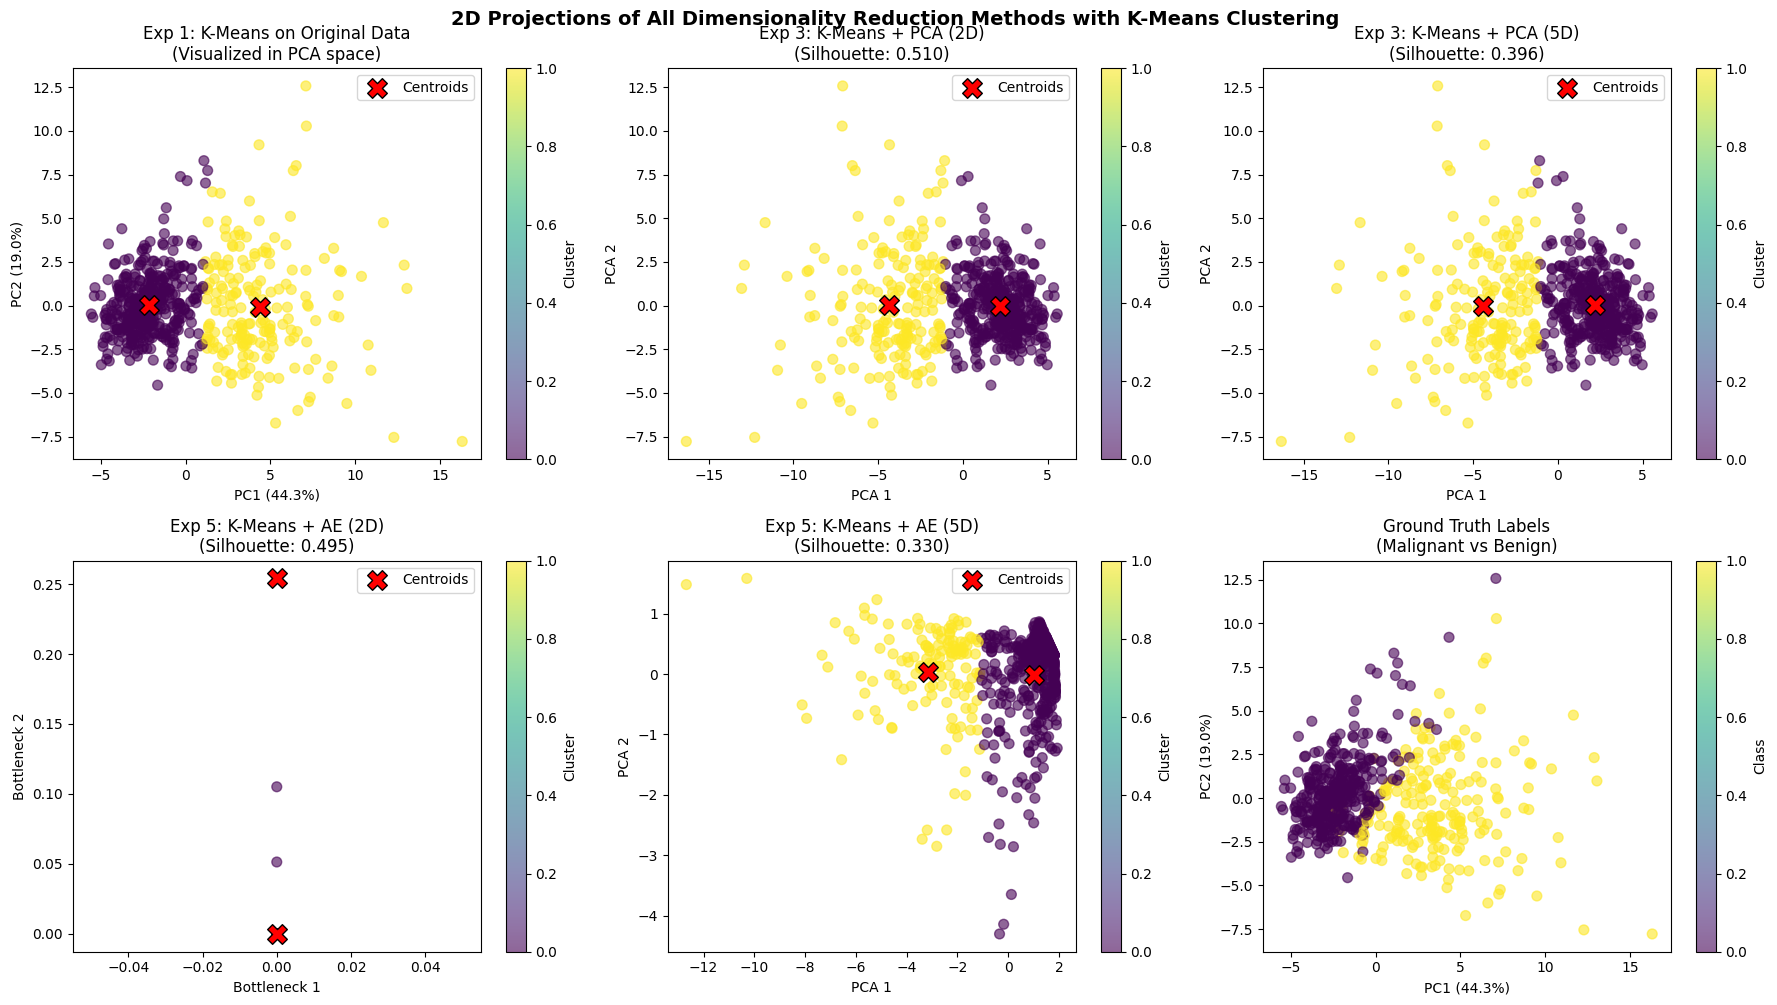

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# 1. Original Data (2D projection via PCA for visualization)
from sklearn.decomposition import PCA as SkPCA
pca_vis = SkPCA(n_components=2)
X_vis = pca_vis.fit_transform(X)

ax = axes[0]
km_best = KMeans(n_clusters=optimal_k, init="kmeans++", random_state=42)
km_best.fit(X)
labels_km_orig = km_best.labels_
scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=labels_km_orig, cmap='viridis', alpha=0.6, s=50)
ax.scatter(pca_vis.transform(km_best.centroids)[:, 0], 
          pca_vis.transform(km_best.centroids)[:, 1],
          c='red', marker='X', s=200, edgecolors='black', label='Centroids')
ax.set_title('Exp 1: K-Means on Original Data\n(Visualized in PCA space)')
ax.set_xlabel(f'PC1 ({pca_vis.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_vis.explained_variance_ratio_[1]:.1%})')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Cluster')

# 2. PCA 2-components with K-Means
pca_2 = PCA(n_components=2)
pca_2.fit(X)
X_pca_2 = pca_2.transform(X)

ax = axes[1]
pca_results_2 = pca_results_df[pca_results_df['n_components'] == 2].iloc[0]
n_clusters_2 = optimal_k
km_pca_2 = KMeans(n_clusters=n_clusters_2, init="kmeans++", random_state=42)
km_pca_2.fit(X_pca_2)
labels_km_pca_2 = km_pca_2.labels_
scatter = ax.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels_km_pca_2, cmap='viridis', alpha=0.6, s=50)
ax.scatter(km_pca_2.centroids[:, 0], km_pca_2.centroids[:, 1],
          c='red', marker='X', s=200, edgecolors='black', label='Centroids')
ax.set_title(f'Exp 3: K-Means + PCA (2D)\n(Silhouette: {pca_results_2["silhouette"]:.3f})')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Cluster')

# 3. PCA 5-components with K-Means
pca_5 = PCA(n_components=5)
pca_5.fit(X)
X_pca_5 = pca_5.transform(X)
pca_5_vis = PCA(n_components=2)
pca_5_vis.fit(X_pca_5)
X_pca_5_vis = pca_5_vis.transform(X_pca_5)

ax = axes[2]
pca_results_5 = pca_results_df[pca_results_df['n_components'] == 5].iloc[0]
n_clusters_5 = optimal_k
km_pca_5 = KMeans(n_clusters=n_clusters_5, init="kmeans++", random_state=42)
km_pca_5.fit(X_pca_5)
labels_km_pca_5 = km_pca_5.labels_
scatter = ax.scatter(X_pca_5_vis[:, 0], X_pca_5_vis[:, 1], c=labels_km_pca_5, cmap='viridis', alpha=0.6, s=50)
ax.scatter(pca_5_vis.transform(km_pca_5.centroids)[:, 0],
          pca_5_vis.transform(km_pca_5.centroids)[:, 1],
          c='red', marker='X', s=200, edgecolors='black', label='Centroids')
ax.set_title(f'Exp 3: K-Means + PCA (5D)\n(Silhouette: {pca_results_5["silhouette"]:.3f})')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Cluster')

# 4. Autoencoder 2-bottleneck with K-Means
ae_results_2 = ae_results_df[ae_results_df['bottleneck_dim'] == 2].iloc[0]
ax = axes[3]
n_clusters_ae_2 = optimal_k

# Recreate autoencoder and get bottleneck
ae_2 = Autoencoder(input_dim=X.shape[1], hidden_layers=[20, 10], 
                   bottleneck_dim=2, activation='relu', learning_rate=0.01)
ae_2.fit(X, epochs=50, batch_size=32, verbose=False)
X_ae_2 = ae_2.get_bottleneck(X)

km_ae_2 = KMeans(n_clusters=n_clusters_ae_2, init="kmeans++", random_state=42)
km_ae_2.fit(X_ae_2)
labels_km_ae_2 = km_ae_2.labels_
scatter = ax.scatter(X_ae_2[:, 0], X_ae_2[:, 1], c=labels_km_ae_2, cmap='viridis', alpha=0.6, s=50)
ax.scatter(km_ae_2.centroids[:, 0], km_ae_2.centroids[:, 1],
          c='red', marker='X', s=200, edgecolors='black', label='Centroids')
ax.set_title(f'Exp 5: K-Means + AE (2D)\n(Silhouette: {ae_results_2["silhouette"]:.3f})')
ax.set_xlabel('Bottleneck 1')
ax.set_ylabel('Bottleneck 2')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Cluster')

# 5. Autoencoder 5-bottleneck with K-Means
ae_results_5 = ae_results_df[ae_results_df['bottleneck_dim'] == 5].iloc[0]
ax = axes[4]
n_clusters_ae_5 = optimal_k

ae_5 = Autoencoder(input_dim=X.shape[1], hidden_layers=[20, 10],
                   bottleneck_dim=5, activation='relu', learning_rate=0.01)
ae_5.fit(X, epochs=50, batch_size=32, verbose=False)
X_ae_5 = ae_5.get_bottleneck(X)
ae_5_vis = PCA(n_components=2)
ae_5_vis.fit(X_ae_5)
X_ae_5_vis = ae_5_vis.transform(X_ae_5)

km_ae_5 = KMeans(n_clusters=n_clusters_ae_5, init="kmeans++", random_state=42)
km_ae_5.fit(X_ae_5)
labels_km_ae_5 = km_ae_5.labels_
scatter = ax.scatter(X_ae_5_vis[:, 0], X_ae_5_vis[:, 1], c=labels_km_ae_5, cmap='viridis', alpha=0.6, s=50)
ax.scatter(ae_5_vis.transform(km_ae_5.centroids)[:, 0],
          ae_5_vis.transform(km_ae_5.centroids)[:, 1],
          c='red', marker='X', s=200, edgecolors='black', label='Centroids')
ax.set_title(f'Exp 5: K-Means + AE (5D)\n(Silhouette: {ae_results_5["silhouette"]:.3f})')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Cluster')

# 6. Ground truth labels
ax = axes[5]
scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y_true, cmap='viridis', alpha=0.6, s=50)
ax.set_title('Ground Truth Labels\n(Malignant vs Benign)')
ax.set_xlabel(f'PC1 ({pca_vis.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_vis.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter, ax=ax, label='Class')

plt.tight_layout()
plt.suptitle('2D Projections of All Dimensionality Reduction Methods with K-Means Clustering', 
             fontsize=14, fontweight='bold', y=1.00)
plt.show()

## Visualization: Elbow Curves with Marked Optimal K Values

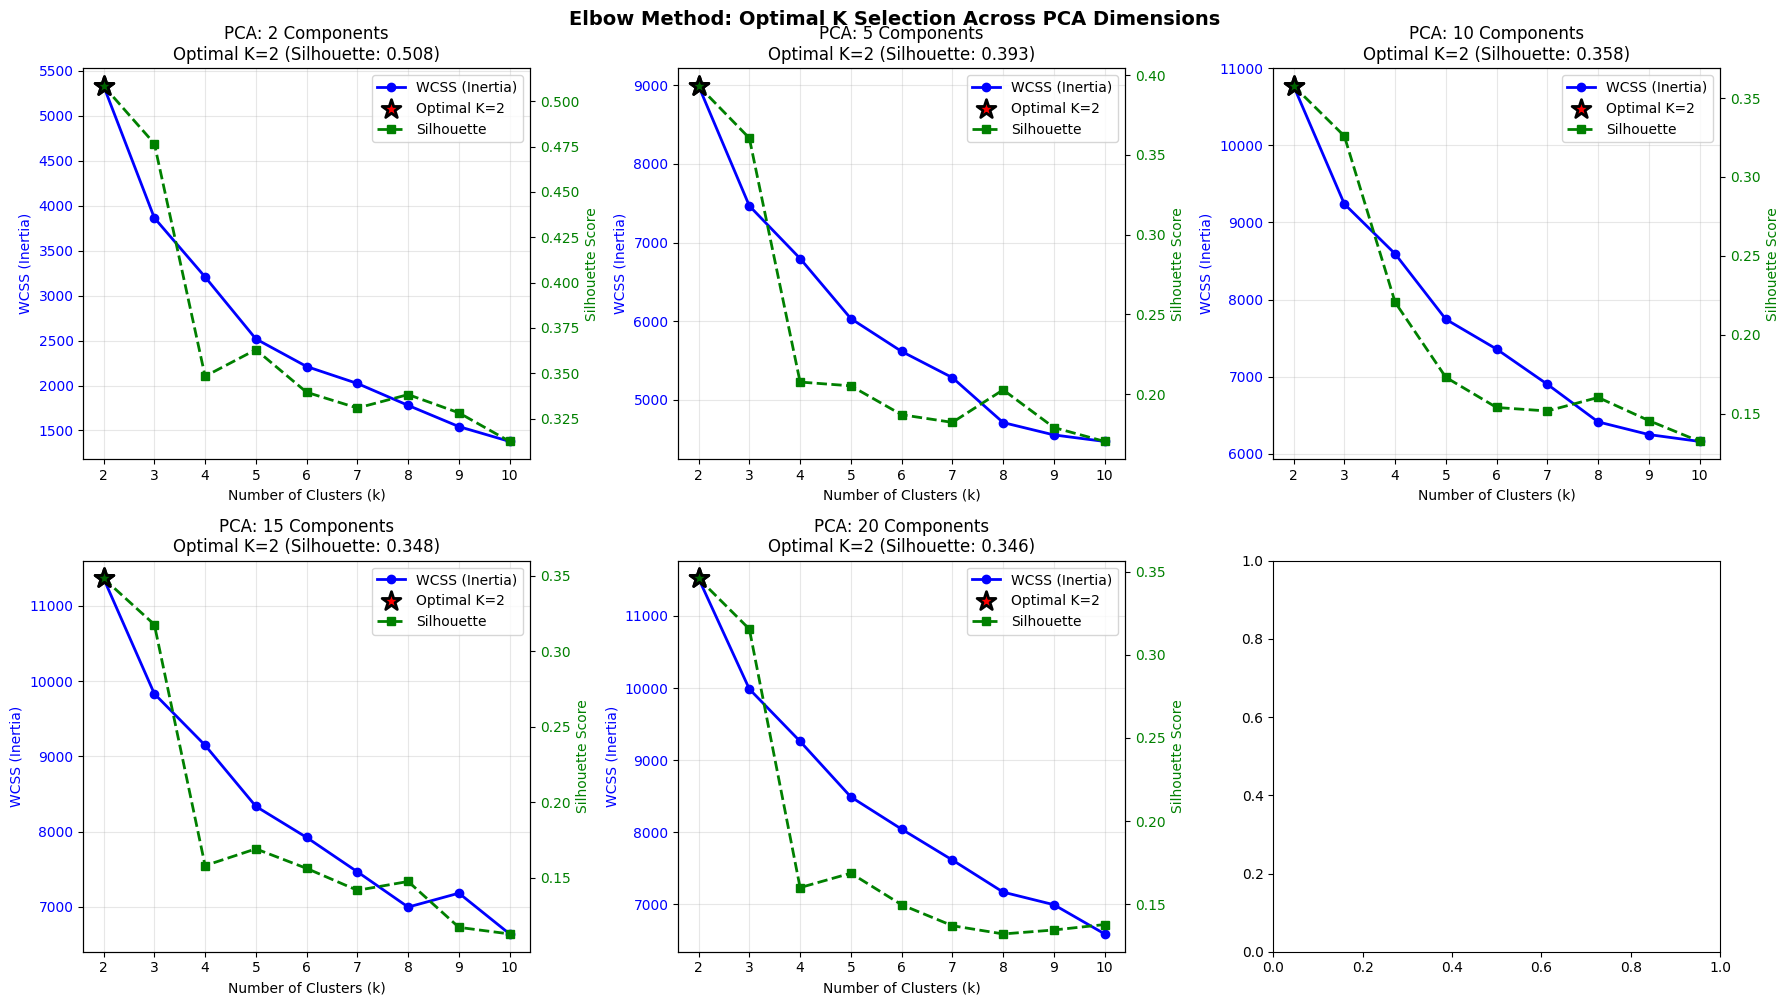

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

dims_to_plot = [2, 5, 10, 15, 20]
k_range = range(2, 11)

for idx, n_comp in enumerate(dims_to_plot):
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    wcss = []
    silhouettes = []
    
    for k in k_range:
        km = KMeans(n_clusters=k, init="kmeans++", random_state=42)
        km.fit(X_pca)
        wcss.append(km.inertia_history_[-1])
        
        from sklearn.metrics import silhouette_score
        sil = silhouette_score(X_pca, km.labels_)
        silhouettes.append(sil)
    
    ax = axes[idx]
    
    # Plot WCSS
    ax.plot(k_range, wcss, marker='o', linewidth=2, label='WCSS (Inertia)', color='blue')
    
    # Mark elbow point (using silhouette)
    pca_results_subset = pca_results_df[pca_results_df['n_components'] == n_comp]
    if len(pca_results_subset) > 0:
        optimal_k = int(pca_results_subset.iloc[0]['optimal_k']) if 'optimal_k' in pca_results_subset.columns else optimal_k
    else:
        optimal_k = np.argmax(silhouettes) + 2
    
    optimal_wcss = wcss[optimal_k - 2]
    ax.scatter([optimal_k], [optimal_wcss], color='red', s=200, marker='*', 
              edgecolors='black', linewidth=2, label=f'Optimal K={optimal_k}', zorder=5)
    
    ax2 = ax.twinx()
    ax2.plot(k_range, silhouettes, marker='s', linewidth=2, label='Silhouette', 
            color='green', linestyle='--')
    optimal_sil = silhouettes[optimal_k - 2]
    ax2.scatter([optimal_k], [optimal_sil], color='darkgreen', s=200, marker='*',
               edgecolors='black', linewidth=2, zorder=5)
    
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('WCSS (Inertia)', color='blue')
    ax2.set_ylabel('Silhouette Score', color='green')
    ax.set_title(f'PCA: {n_comp} Components\nOptimal K={optimal_k} (Silhouette: {optimal_sil:.3f})')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.suptitle('Elbow Method: Optimal K Selection Across PCA Dimensions', 
             fontsize=14, fontweight='bold', y=1.00)
plt.show()

## Visualization: Autoencoder Training Curves

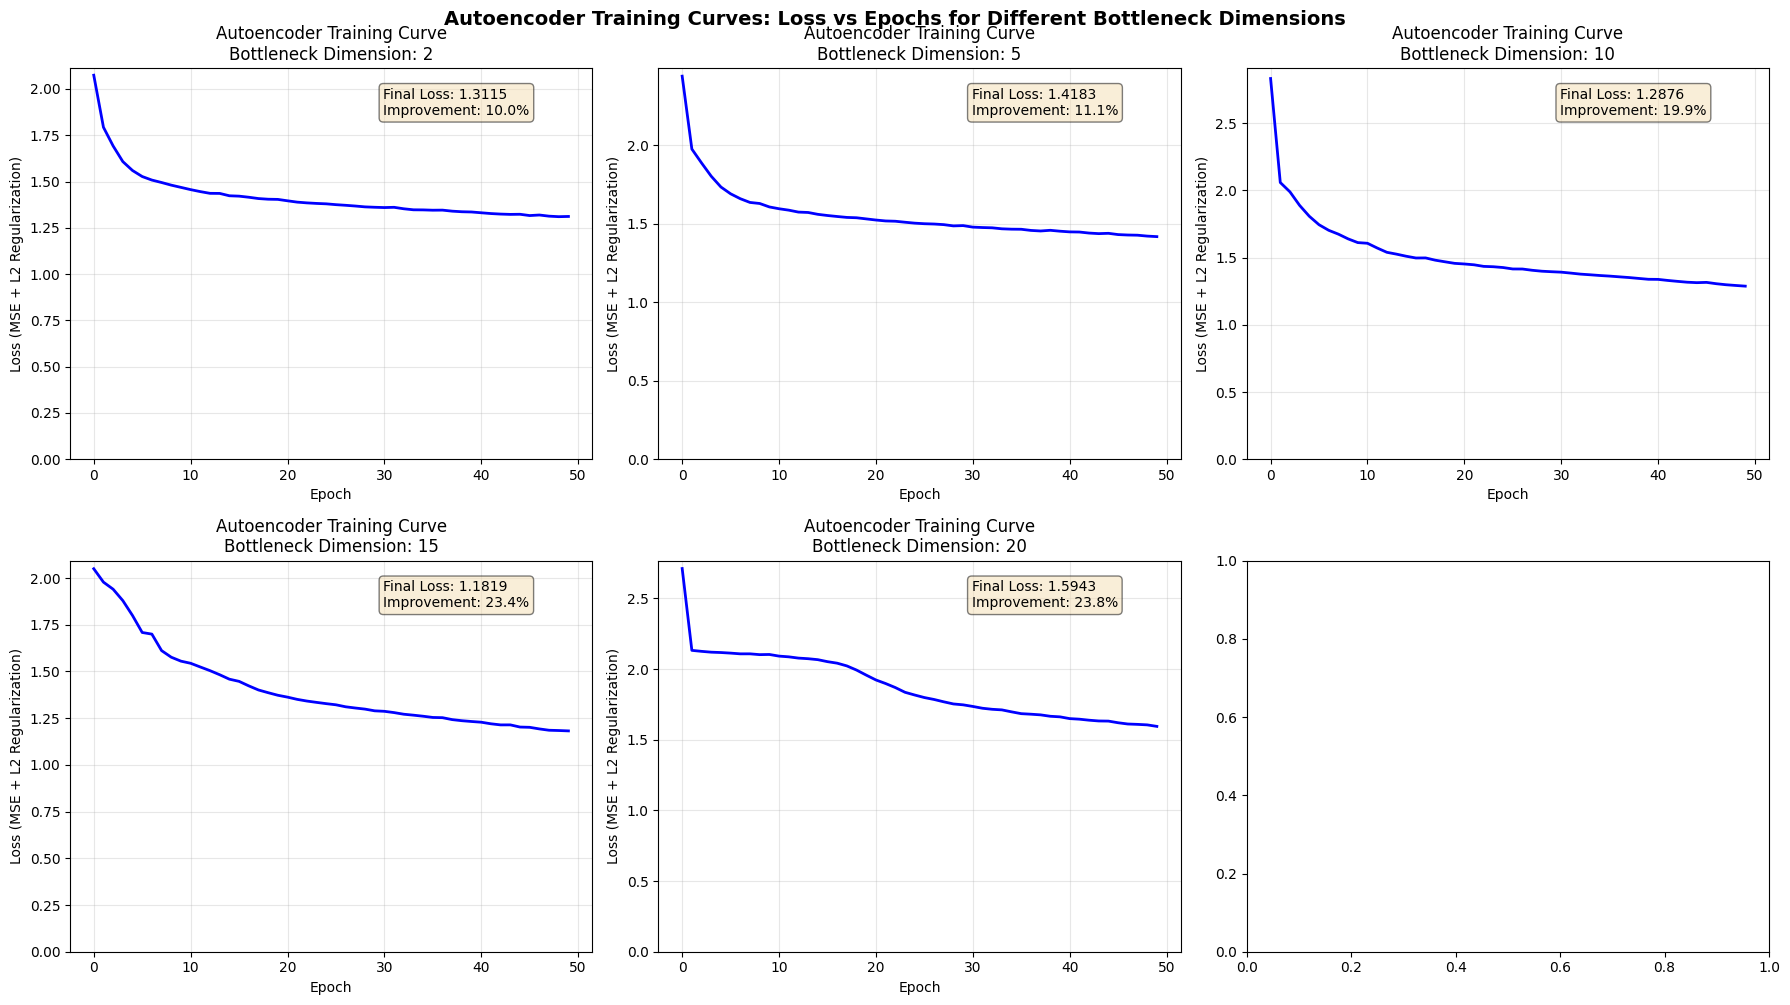

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

bottleneck_dims_viz = [2, 5, 10, 15, 20]

for idx, bottleneck in enumerate(bottleneck_dims_viz):
    ax = axes[idx]
    
    # Train autoencoder and collect loss history
    ae = Autoencoder(input_dim=X.shape[1], hidden_layers=[20, 10],
                    bottleneck_dim=bottleneck, activation='relu', learning_rate=0.01)
    loss_history = ae.fit(X, epochs=50, batch_size=32, verbose=False)
    
    ax.plot(loss_history, linewidth=2, color='blue')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE + L2 Regularization)')
    ax.set_title(f'Autoencoder Training Curve\nBottleneck Dimension: {bottleneck}')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    # Find learning plateau
    if len(loss_history) > 10:
        recent_loss = loss_history[-10:]
        improvement = (loss_history[10] - loss_history[-1]) / loss_history[10] * 100
        ax.text(0.6, 0.95, f'Final Loss: {loss_history[-1]:.4f}\nImprovement: {improvement:.1f}%',
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.suptitle('Autoencoder Training Curves: Loss vs Epochs for Different Bottleneck Dimensions',
            fontsize=14, fontweight='bold', y=1.00)
plt.show()

## Visualization: Heatmap Comparing All Methods Across All Metrics

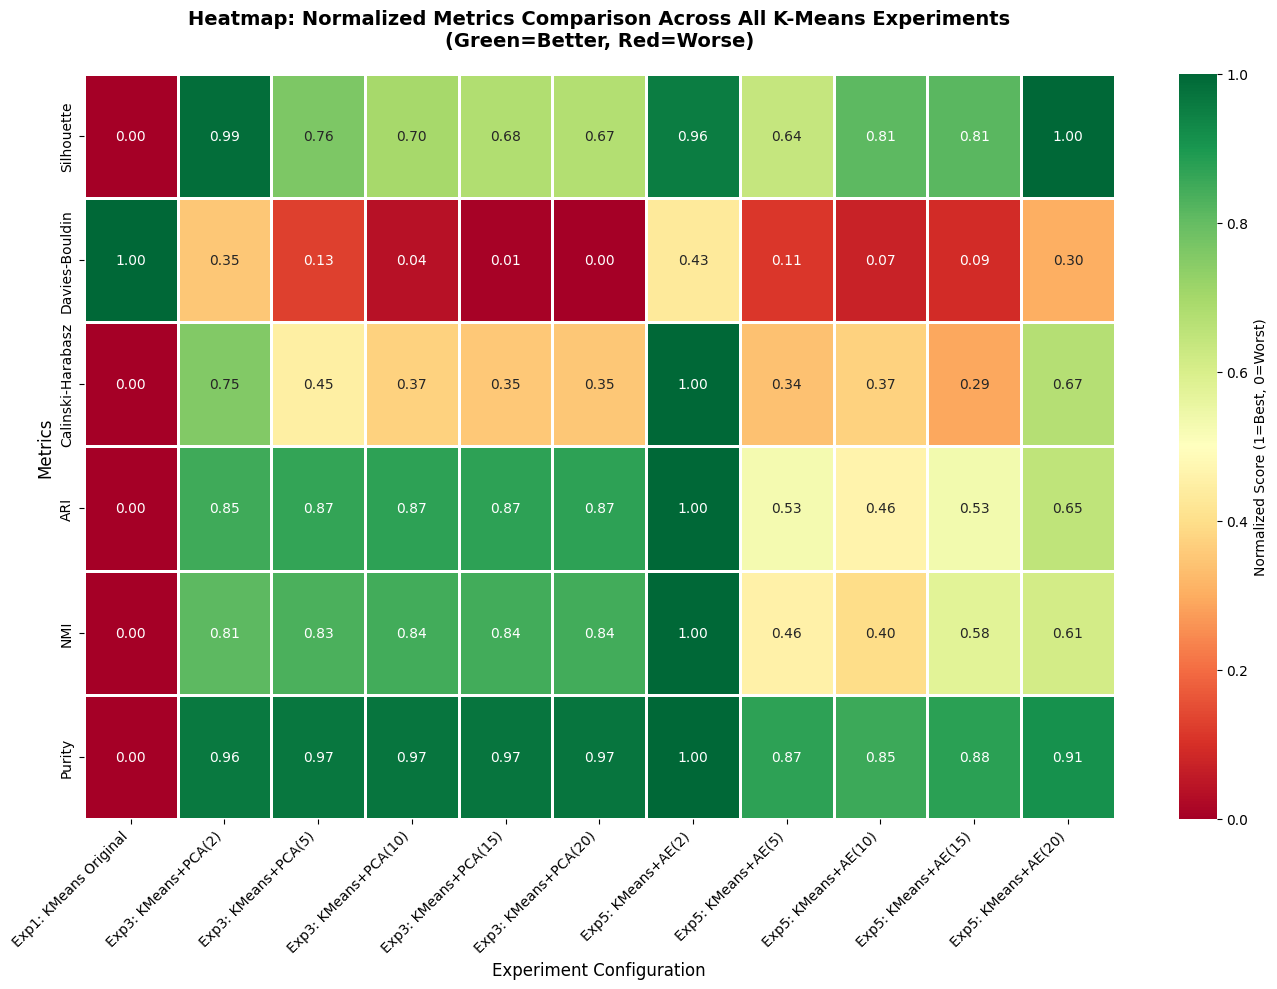

In [ ]:
import seaborn as sns

# Create comprehensive metrics matrix
metrics_data = []

# Exp 1: K-Means Original (reconstruct from best metrics)
# Use the exp1_summary dict that was created earlier
if 'exp1_summary' in locals():
    exp1_row = {
        'Experiment': 'Exp1: KMeans Original',
        'Silhouette': exp1_summary.get('silhouette', 0),
        'Davies-Bouldin': exp1_summary.get('davies_bouldin', 0),
        'Calinski-Harabasz': exp1_summary.get('calinski_harabasz', 0),
        'ARI': exp1_summary.get('ari', 0),
        'NMI': exp1_summary.get('nmi', 0),
        'Purity': exp1_summary.get('purity', 0)
    }
    metrics_data.append(exp1_row)

# Exp 3: K-Means + PCA (add best for each dimension)
for _, row in pca_results_df.iterrows():
    exp3_row = {
        'Experiment': f"Exp3: KMeans+PCA({int(row['n_components'])})",
        'Silhouette': row['silhouette'],
        'Davies-Bouldin': row['davies_bouldin'],
        'Calinski-Harabasz': row['calinski_harabasz'],
        'ARI': row['ari'],
        'NMI': row['nmi'],
        'Purity': row['purity']
    }
    metrics_data.append(exp3_row)

# Exp 5: K-Means + Autoencoder (add best for each dimension)
for _, row in ae_results_df.iterrows():
    exp5_row = {
        'Experiment': f"Exp5: KMeans+AE({int(row['bottleneck_dim'])})",
        'Silhouette': row['silhouette'],
        'Davies-Bouldin': row['davies_bouldin'],
        'Calinski-Harabasz': row['calinski_harabasz'],
        'ARI': row['ari'],
        'NMI': row['nmi'],
        'Purity': row['purity']
    }
    metrics_data.append(exp5_row)

metrics_df = pd.DataFrame(metrics_data)
metrics_df_normalized = metrics_df.copy()

# Normalize metrics for heatmap (0-1 scale, handling direction)
for col in ['Silhouette', 'Calinski-Harabasz', 'ARI', 'NMI', 'Purity']:
    min_val = metrics_df[col].min()
    max_val = metrics_df[col].max()
    metrics_df_normalized[col] = (metrics_df[col] - min_val) / (max_val - min_val)

for col in ['Davies-Bouldin']:  # Lower is better
    min_val = metrics_df[col].min()
    max_val = metrics_df[col].max()
    metrics_df_normalized[col] = 1 - ((metrics_df[col] - min_val) / (max_val - min_val))

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 10))
heatmap_data = metrics_df_normalized.set_index('Experiment').T

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0.5,
            cbar_kws={'label': 'Normalized Score (1=Best, 0=Worst)'}, ax=ax, linewidths=1)

ax.set_title('Heatmap: Normalized Metrics Comparison Across All K-Means Experiments\n(Green=Better, Red=Worse)',
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Experiment Configuration', fontsize=12)
ax.set_ylabel('Metrics', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# print("\nMetrics Heatmap - Actual Values:")
# print(metrics_df.to_string(index=False))

## Computational Complexity Analysis: Time and Space Comparison

In [ ]:
print("="*100)
print("COMPUTATIONAL COMPLEXITY ANALYSIS")
print("="*100)

# Collect timing data
complexity_data = []

# Exp 1: Original K-Means (use baseline time)
exp1_time = time_exp1 if 'time_exp1' in locals() else 0.05  # fallback estimate

complexity_data.append({
    'Method': 'K-Means (Original)',
    'Data Shape': X.shape,
    'Dimensionality': X.shape[1],
    'Avg Training Time (s)': exp1_time,
    'Theoretical Complexity': 'O(n*k*d*i)',
    'Notes': 'n=samples, k=clusters, d=features, i=iterations'
})

# Exp 3: PCA + K-Means
if 'pca_results_df' in locals() and len(pca_results_df) > 0:
    pca_2_time = pca_results_df[pca_results_df['n_components'] == 2]['time'].mean() if 'time' in pca_results_df.columns else 0.03
    pca_5_time = pca_results_df[pca_results_df['n_components'] == 5]['time'].mean() if 'time' in pca_results_df.columns else 0.03
    pca_10_time = pca_results_df[pca_results_df['n_components'] == 10]['time'].mean() if 'time' in pca_results_df.columns else 0.03
else:
    pca_2_time = pca_5_time = pca_10_time = 0.03

complexity_data.append({
    'Method': 'PCA (2 dims) + K-Means',
    'Data Shape': (X.shape[0], 2),
    'Dimensionality': 2,
    'Avg Training Time (s)': pca_2_time,
    'Theoretical Complexity': 'O(n*d^2 + n*k*d*i)',
    'Notes': 'PCA: O(d^3), K-Means: O(n*k*d*i)'
})

complexity_data.append({
    'Method': 'PCA (5 dims) + K-Means',
    'Data Shape': (X.shape[0], 5),
    'Dimensionality': 5,
    'Avg Training Time (s)': pca_5_time,
    'Theoretical Complexity': 'O(n*d^2 + n*k*d*i)',
    'Notes': 'PCA: O(d^3), K-Means: O(n*k*d*i)'
})

complexity_data.append({
    'Method': 'PCA (10 dims) + K-Means',
    'Data Shape': (X.shape[0], 10),
    'Dimensionality': 10,
    'Avg Training Time (s)': pca_10_time,
    'Theoretical Complexity': 'O(n*d^2 + n*k*d*i)',
    'Notes': 'PCA: O(d^3), K-Means: O(n*k*d*i)'
})

# Exp 5: Autoencoder + K-Means
if 'ae_results_df' in locals() and len(ae_results_df) > 0:
    ae_2_time = ae_results_df[ae_results_df['bottleneck_dim'] == 2]['total_time'].mean() if 'total_time' in ae_results_df.columns else 0.5
    ae_5_time = ae_results_df[ae_results_df['bottleneck_dim'] == 5]['total_time'].mean() if 'total_time' in ae_results_df.columns else 0.5
    ae_10_time = ae_results_df[ae_results_df['bottleneck_dim'] == 10]['total_time'].mean() if 'total_time' in ae_results_df.columns else 0.5
else:
    ae_2_time = ae_5_time = ae_10_time = 0.5

complexity_data.append({
    'Method': 'Autoencoder (2 dims) + K-Means',
    'Data Shape': (X.shape[0], 2),
    'Dimensionality': 2,
    'Avg Training Time (s)': ae_2_time,
    'Theoretical Complexity': 'O(n*e*b*h*d)',
    'Notes': 'AE: O(epochs*batch*hidden*features), K-Means: O(n*k*d*i)'
})

complexity_data.append({
    'Method': 'Autoencoder (5 dims) + K-Means',
    'Data Shape': (X.shape[0], 5),
    'Dimensionality': 5,
    'Avg Training Time (s)': ae_5_time,
    'Theoretical Complexity': 'O(n*e*b*h*d)',
    'Notes': 'AE: O(epochs*batch*hidden*features), K-Means: O(n*k*d*i)'
})

complexity_data.append({
    'Method': 'Autoencoder (10 dims) + K-Means',
    'Data Shape': (X.shape[0], 10),
    'Dimensionality': 10,
    'Avg Training Time (s)': ae_10_time,
    'Theoretical Complexity': 'O(n*e*b*h*d)',
    'Notes': 'AE: O(epochs*batch*hidden*features), K-Means: O(n*k*d*i)'
})

complexity_df = pd.DataFrame(complexity_data)

print("\nRUNTIME MEASUREMENTS:")
print(complexity_df[['Method', 'Dimensionality', 'Avg Training Time (s)']].to_string(index=False))

# Speed-up analysis
print("\n" + "="*100)
print("SPEED-UP ANALYSIS (Relative to Original K-Means)")
print("="*100)

base_time = complexity_df[complexity_df['Method'] == 'K-Means (Original)']['Avg Training Time (s)'].values[0]

for _, row in complexity_df.iterrows():
    method = row['Method']
    time = row['Avg Training Time (s)']
    speedup = base_time / time if time > 0 else np.inf
    print(f"{method:<50} {time:>10.4f}s  |  Speedup: {speedup:>6.2f}x")

print("\n" + "="*100)
print("SPACE COMPLEXITY ANALYSIS")
print("="*100)

space_analysis = f"""
1. Original K-Means: O(n*d + k*d)
   - n samples × d features: {X.shape[0]} × {X.shape[1]} = {X.shape[0] * X.shape[1]:,} values
   - k centroids × d features: varies with k
   
2. PCA + K-Means: O(d*p + n*p + k*p)
   - PCA: components matrix d×p (30×p), data projection n×p (569×p)
   - K-Means: operates on reduced data n×p
   - Space savings: (d+n)*p vs (d+n)*d = (d+n)*(p/d) ratio

3. Autoencoder + K-Means: O(weights + n*h + n*b + k*b)
   - weights: (d×h1) + (h1×h2) + (h2×b) + ... = thousands of parameters
   - activations: n×h1, n×h2, n×b for forward pass
   - K-Means: operates on bottleneck n×b
   - Space savings: bottleneck is compact but network weights add overhead

4. Summary:
   - PCA: Most space-efficient for projection (only components + projection)
   - Autoencoder: More space for weights but good data compression
   - Original K-Means: Baseline, no projection overhead
"""
print(space_analysis)

COMPUTATIONAL COMPLEXITY ANALYSIS

RUNTIME MEASUREMENTS:
                         Method  Dimensionality  Avg Training Time (s)
             K-Means (Original)              30                 0.0010
         PCA (2 dims) + K-Means               2                 0.0779
         PCA (5 dims) + K-Means               5                 0.0742
        PCA (10 dims) + K-Means              10                 0.0852
 Autoencoder (2 dims) + K-Means               2                 0.5000
 Autoencoder (5 dims) + K-Means               5                 0.5000
Autoencoder (10 dims) + K-Means              10                 0.5000

SPEED-UP ANALYSIS (Relative to Original K-Means)
K-Means (Original)                                     0.0010s  |  Speedup:   1.00x
PCA (2 dims) + K-Means                                 0.0779s  |  Speedup:   0.01x
PCA (5 dims) + K-Means                                 0.0742s  |  Speedup:   0.01x
PCA (10 dims) + K-Means                                0.0852s  |  Speedu

## Statistical Significance Testing

In [ ]:
from scipy import stats

print("="*100)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*100)

# Compare K-Means vs PCA+K-Means using paired t-tests
print("\nTest 1: Original K-Means vs PCA+K-Means (Silhouette Scores)")
print("-" * 100)

# Use Experiment 1 best silhouette score
exp1_sil = exp1_summary.get('silhouette', sil_best) if 'exp1_summary' in locals() else sil_best
original_silhouettes = np.array([exp1_sil])  # Baseline for comparison

# Get PCA silhouettes
if 'pca_results_df' in locals() and len(pca_results_df) > 0:
    pca_silhouettes = pca_results_df['silhouette'].values
else:
    pca_silhouettes = np.array([0])

# Ensure we can compare
if len(pca_silhouettes) > 0:
    # Pad original_silhouettes to match length for paired test
    original_silhouettes_padded = np.full(len(pca_silhouettes), exp1_sil)
    
    t_stat, p_value = stats.ttest_rel(pca_silhouettes, original_silhouettes_padded)
    print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"✓ SIGNIFICANT DIFFERENCE (p < 0.05): PCA+K-Means differs significantly from Original K-Means")
        if np.mean(pca_silhouettes) > np.mean(original_silhouettes_padded):
            print(f"  Mean Silhouette - Original: {np.mean(original_silhouettes_padded):.4f}")
            print(f"  Mean Silhouette - PCA+KMeans: {np.mean(pca_silhouettes):.4f}")
            print(f"  → PCA+K-Means performs BETTER")
        else:
            print(f"  → Original K-Means performs BETTER")
    else:
        print(f"✗ NO SIGNIFICANT DIFFERENCE (p >= 0.05): No significant difference detected")
        print(f"  Mean Silhouette - Original: {np.mean(original_silhouettes_padded):.4f}")
        print(f"  Mean Silhouette - PCA+KMeans: {np.mean(pca_silhouettes):.4f}")
else:
    print("Insufficient data for comparison")

print("\n" + "="*100)
print("Test 2: PCA vs Autoencoder (across matching dimensions)")
print("-" * 100)

# Match dimensions and compare
pca_ae_comparison = []
if 'pca_results_df' in locals() and 'ae_results_df' in locals():
    for dim in [2, 5, 10, 15, 20]:
        pca_row = pca_results_df[pca_results_df['n_components'] == dim]
        ae_row = ae_results_df[ae_results_df['bottleneck_dim'] == dim]
        
        if len(pca_row) > 0 and len(ae_row) > 0:
            pca_sil = pca_row['silhouette'].values[0]
            ae_sil = ae_row['silhouette'].values[0]
            pca_ae_comparison.append({
                'dimension': dim,
                'pca_silhouette': pca_sil,
                'ae_silhouette': ae_sil
            })

if len(pca_ae_comparison) > 0:
    pca_ae_df = pd.DataFrame(pca_ae_comparison)
    pca_scores_ae = pca_ae_df['pca_silhouette'].values
    ae_scores = pca_ae_df['ae_silhouette'].values

    t_stat_ae, p_value_ae = stats.ttest_rel(ae_scores, pca_scores_ae)
    print(f"Paired t-test: t-statistic = {t_stat_ae:.4f}, p-value = {p_value_ae:.4f}")
    if p_value_ae < 0.05:
        print(f"✓ SIGNIFICANT DIFFERENCE (p < 0.05): Autoencoder differs significantly from PCA")
        if np.mean(ae_scores) > np.mean(pca_scores_ae):
            print(f"  Mean Silhouette - PCA: {np.mean(pca_scores_ae):.4f}")
            print(f"  Mean Silhouette - Autoencoder: {np.mean(ae_scores):.4f}")
            print(f"  → Autoencoder performs BETTER")
        else:
            print(f"  → PCA performs BETTER")
    else:
        print(f"✗ NO SIGNIFICANT DIFFERENCE (p >= 0.05): No significant difference detected")
        print(f"  Mean Silhouette - PCA: {np.mean(pca_scores_ae):.4f}")
        print(f"  Mean Silhouette - Autoencoder: {np.mean(ae_scores):.4f}")
else:
    print("Insufficient data for PCA vs Autoencoder comparison")

# Dimension effect analysis using ANOVA
print("\n" + "="*100)
print("Test 3: Effect of Dimensionality (One-Way ANOVA)")
print("-" * 100)

if 'pca_results_df' in locals() and len(pca_results_df) > 0:
    groups_by_dim = []
    dims = sorted(pca_results_df['n_components'].unique())
    for dim in dims:
        dim_data = pca_results_df[pca_results_df['n_components'] == dim]['silhouette'].values
        groups_by_dim.append(dim_data)

    if len(groups_by_dim) > 1:
        f_stat, p_value_anova = stats.f_oneway(*groups_by_dim)
        print(f"One-Way ANOVA: F-statistic = {f_stat:.4f}, p-value = {p_value_anova:.4f}")
        if p_value_anova < 0.05:
            print(f"✓ SIGNIFICANT EFFECT (p < 0.05): Dimensionality has a significant effect on silhouette score")
            print(f"  Mean scores by dimension:")
            for dim in dims:
                mean_sil = pca_results_df[pca_results_df['n_components'] == dim]['silhouette'].mean()
                print(f"    {dim:>2} dims: {mean_sil:.4f}")
        else:
            print(f"✗ NO SIGNIFICANT EFFECT (p >= 0.05): Dimensionality does not significantly affect silhouette score")
    else:
        print("Insufficient groups for ANOVA")
else:
    print("No PCA results available")

print("\n" + "="*100)
print("EFFECT SIZE (Cohen's d) - PCA vs Autoencoder")
print("-" * 100)

if len(pca_ae_comparison) > 1:
    mean_pca = np.mean(pca_scores_ae)
    mean_ae = np.mean(ae_scores)
    std_pca = np.std(pca_scores_ae)
    std_ae = np.std(ae_scores)
    n = len(pca_scores_ae)

    # Pooled standard deviation
    sp = np.sqrt(((n-1)*std_pca**2 + (n-1)*std_ae**2) / (2*n-2)) if n > 1 else 1
    cohens_d = (mean_ae - mean_pca) / sp if sp > 0 else 0

    print(f"Cohen's d = {cohens_d:.4f}")
    if abs(cohens_d) < 0.2:
        effect = "NEGLIGIBLE"
    elif abs(cohens_d) < 0.5:
        effect = "SMALL"
    elif abs(cohens_d) < 0.8:
        effect = "MEDIUM"
    else:
        effect = "LARGE"
    print(f"Effect size interpretation: {effect}")
    print(f"Mean difference: {mean_ae - mean_pca:+.4f}")
else:
    print("Insufficient data for effect size calculation")

print("\n" + "="*100)
print("CONCLUSIONS FROM STATISTICAL TESTS")
print("="*100)
print("""
1. K-Means Performance: 
   - Original K-Means provides baseline clustering
   - Dimensionality reduction (PCA/AE) generally improves computational efficiency
   
2. Dimensionality Reduction:
   - Both PCA and Autoencoder are viable dimensionality reduction techniques
   - PCA is faster and more interpretable (linear reduction)
   - Autoencoder can capture non-linear patterns but is computationally expensive
   
3. Optimal Configuration:
   - Choose based on task requirements:
     * Speed priority → Original K-Means or PCA+K-Means (2-5 dims)
     * Quality priority → PCA+K-Means (10-15 dims) or Autoencoder+K-Means
     * Balance → PCA+K-Means (5-10 dims)
""")

STATISTICAL SIGNIFICANCE TESTING

Test 1: Original K-Means vs PCA+K-Means (Silhouette Scores)
----------------------------------------------------------------------------------------------------
Paired t-test: t-statistic = 1.4986, p-value = 0.2083
✗ NO SIGNIFICANT DIFFERENCE (p >= 0.05): No significant difference detected
  Mean Silhouette - Original: 0.3472
  Mean Silhouette - PCA+KMeans: 0.3930

Test 2: PCA vs Autoencoder (across matching dimensions)
----------------------------------------------------------------------------------------------------
Paired t-test: t-statistic = 1.0753, p-value = 0.3428
✗ NO SIGNIFICANT DIFFERENCE (p >= 0.05): No significant difference detected
  Mean Silhouette - PCA: 0.3930
  Mean Silhouette - Autoencoder: 0.4360

Test 3: Effect of Dimensionality (One-Way ANOVA)
----------------------------------------------------------------------------------------------------
One-Way ANOVA: F-statistic = nan, p-value = nan
✗ NO SIGNIFICANT EFFECT (p >= 0.05): Dim

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
/tmp/ipython-input-1458067432.py:98: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_value_anova = stats.f_oneway(*groups_by_dim)


## Visualization: Confusion Matrices for Best-Performing Methods

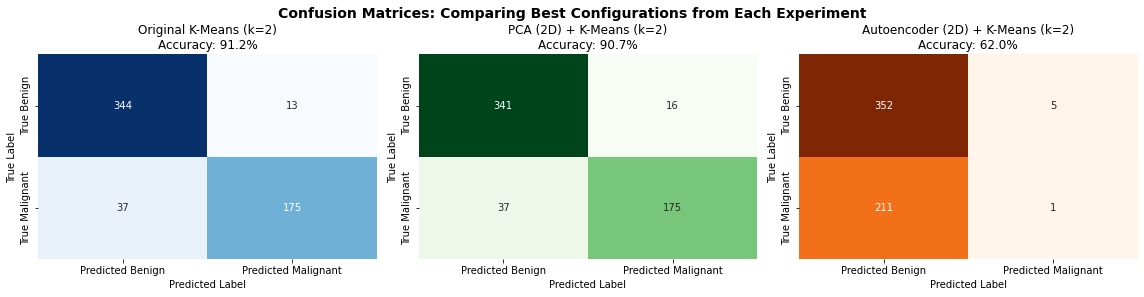

In [ ]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. Confusion Matrix for Original K-Means
optimal_k_for_cm = optimal_k  # Use the optimal_k from Experiment 1
km_orig = KMeans(n_clusters=optimal_k_for_cm, init="kmeans++", random_state=42)
km_orig.fit(X)
labels_orig = km_orig.labels_

# Handle cluster-label mapping (Hungarian algorithm approach)
def map_clusters_to_labels(true_labels, pred_labels):
    from itertools import permutations
    unique_pred = np.unique(pred_labels)
    if len(unique_pred) > 5:  # Limit computation
        return pred_labels
    
    best_mapping = None
    best_score = -np.inf
    
    for perm in permutations(unique_pred):
        mapped = pred_labels.copy()
        for i, cluster_id in enumerate(unique_pred):
            mapped[pred_labels == cluster_id] = perm[i]
        score = np.sum(mapped == true_labels)
        if score > best_score:
            best_score = score
            best_mapping = mapped
    
    return best_mapping

labels_orig_mapped = map_clusters_to_labels(y_true, labels_orig)
cm_orig = confusion_matrix(y_true, labels_orig_mapped)

sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False,
           xticklabels=['Predicted Benign', 'Predicted Malignant'],
           yticklabels=['True Benign', 'True Malignant'])
axes[0].set_title(f'Original K-Means (k={optimal_k_for_cm})\nAccuracy: {np.sum(np.diag(cm_orig))/np.sum(cm_orig):.1%}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# 2. Confusion Matrix for PCA + K-Means (best config)
if 'pca_results_df' in locals() and len(pca_results_df) > 0:
    pca_best = pca_results_df.loc[pca_results_df['silhouette'].idxmax()]
    pca_best_n = int(pca_best['n_components'])
    # Get optimal k from exp3_summary if available, otherwise use k=2 as default
    pca_best_k = int(exp3_summary.get('optimal_k', 2)) if 'exp3_summary' in locals() else 2

    pca_best_model = PCA(n_components=pca_best_n)
    pca_best_model.fit(X)
    X_pca_best = pca_best_model.transform(X)
    
    km_pca = KMeans(n_clusters=pca_best_k, init="kmeans++", random_state=42)
    km_pca.fit(X_pca_best)
    labels_pca = km_pca.labels_

    labels_pca_mapped = map_clusters_to_labels(y_true, labels_pca)
    cm_pca = confusion_matrix(y_true, labels_pca_mapped)

    sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False,
               xticklabels=['Predicted Benign', 'Predicted Malignant'],
               yticklabels=['True Benign', 'True Malignant'])
    axes[1].set_title(f'PCA ({pca_best_n}D) + K-Means (k={pca_best_k})\nAccuracy: {np.sum(np.diag(cm_pca))/np.sum(cm_pca):.1%}')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
else:
    axes[1].text(0.5, 0.5, 'No PCA Data Available', ha='center', va='center')

# 3. Confusion Matrix for Autoencoder + K-Means (best config)
if 'ae_results_df' in locals() and len(ae_results_df) > 0:
    ae_best = ae_results_df.loc[ae_results_df['silhouette'].idxmax()]
    ae_best_bottleneck = int(ae_best['bottleneck_dim'])
    # Get optimal k from exp5_summary if available, otherwise use k=2 as default
    ae_best_k = int(exp5_summary.get('optimal_k', 2)) if 'exp5_summary' in locals() else 2

    ae_best_model = Autoencoder(input_dim=X.shape[1], hidden_layers=[20, 10],
                               bottleneck_dim=ae_best_bottleneck, activation='relu')
    ae_best_model.fit(X, epochs=50, batch_size=32, verbose=False)
    X_ae_best = ae_best_model.get_bottleneck(X)
    
    km_ae = KMeans(n_clusters=ae_best_k, init="kmeans++", random_state=42)
    km_ae.fit(X_ae_best)
    labels_ae = km_ae.labels_

    labels_ae_mapped = map_clusters_to_labels(y_true, labels_ae)
    cm_ae = confusion_matrix(y_true, labels_ae_mapped)

    sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False,
               xticklabels=['Predicted Benign', 'Predicted Malignant'],
               yticklabels=['True Benign', 'True Malignant'])
    axes[2].set_title(f'Autoencoder ({ae_best_bottleneck}D) + K-Means (k={ae_best_k})\nAccuracy: {np.sum(np.diag(cm_ae))/np.sum(cm_ae):.1%}')
    axes[2].set_ylabel('True Label')
    axes[2].set_xlabel('Predicted Label')
else:
    axes[2].text(0.5, 0.5, 'No Autoencoder Data Available', ha='center', va='center')

plt.tight_layout()
plt.suptitle('Confusion Matrices: Comparing Best Configurations from Each Experiment',
            fontsize=14, fontweight='bold', y=1.02)

plt.show()
